There are several things that I should do here. Regarding the practical/implementation side:
1. Reproduce known results for the PXP model.
    a. Regarding entanglement entropy and possibly other measures that people have used;
    b. Doing real-time dynamics with exact diagonalization and possible some Monte Carlo;
2. Implement and do similar analysis to the extensions of the PXP model.
    a. How do these extensions change the gauge theory?
    b. Implement the case of $\lambda_3$, since $\lambda_1$ should already be corrected implemented.
    c. What happens to scars? Do new ones show up?
    d. Can these be mapped in anyway to the higher dimensional picture? Do Debasesh's analysis for this case and try to establish both a numerical and formal mapping.
3. Explore gauge violating terms. From preliminary analysis it seems that any gauge violation breaks anomalous states
    a. Try to do this systematically;
    b. Are measures like averaging and standard deviations good measures to diagnose presence of scars?
    c. Try the other standard measures like entanglement entropy and such

In [5]:
%matplotlib notebook
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')
%config InlineBackend.figure_format = 'svg'

from matplotlib.pyplot import*
from numpy import zeros, array,log,dot,sqrt,conjugate,real,imag,arange,kron
from numpy import identity,transpose,average,std,sin,pi
from scipy.sparse.linalg import eigs,expm
from scipy.linalg import eigh,eig
from scipy.optimize import minimize
from scipy.sparse import coo_matrix
from pandas import read_csv
from random import random
from copy import deepcopy
from time import time
import pickle
from time import time

# General Functions

In [6]:
def shannon_st(st):
    s=0
    for a in st:
        if abs(a)>0.000000001:
            s-=abs(a**2)*log(abs(a**2))
    return s

def reduced_n(n,L,dic_n2full,dic_full2n,half_n2full,half_full2n):
    st_string=bin(dic_n2full[n])[2:]
    st_string='0'*(L-len(st_string))+st_string
    full2=int(st_string[:L//2],2)
    return half_full2n[full2]

def reduced_matrix(st,L,dic_n2full,dic_full2n,half_n2full,half_full2n):
    N2=len(half_n2full)
    N=len(dic_n2full)
    rho=zeros((N2,N2),complex)
    for n,c in enumerate(st):
        n_2=reduced_n(n,L,dic_n2full,dic_full2n,half_n2full,half_full2n)
        for m,d in enumerate(st):
            m_2=reduced_n(n,L,dic_n2full,dic_full2n,half_n2full,half_full2n)
            rho[m_2,n_2]=c*conjugate(d)
    return rho

def entropy(rho):
    w,v=eigh(rho)
    s=0
    for c in w:
        s-=c*log(c+10**(-10))
    return s

# Constructing the Hamiltonian through tensor products

In [2]:
p0=zeros((2,2),complex);p0[0,0]=1;p0[1,1]=1
p1=zeros((2,2),complex);p1[0,1]=1;p1[1,0]=1
p2=zeros((2,2),complex);p2[0,1]=-1.j;p2[1,0]=1.j
p3=zeros((2,2),complex);p3[0,0]=1;p3[1,1]=-1
pauli=[p0,p1,p2,p3]

In [ ]:
def valid_states(n,pbc=True):
    zers=['0']
    ones=['1']
    for i in range(n-1):
        new_zers=[]
        new_ones=[]
        for w in zers:
            new_zers+=[w+'0']
            if n>2 and i==n-2 and w[0]=='1' and pbc:
                continue
            new_ones+=[w+'1']
        for w in ones:
            new_zers+=[w+'0']
        zers,ones=new_zers,new_ones
    return zers+ones

def dics_states(valid_states):
    dic_n2full={}
    dic_full2n={}
    n=0
    for st in valid_states:
        full=int(st,2)
        dic_n2full[n]=full
        dic_full2n[full]=n
        n+=1
    return dic_n2full,dic_full2n

def HPXP(L,lamb1=0):
    states=valid_states(L)
    dic_n2full,dic_full2n=dics_states(states)
    N=len(states)
    H=zeros((N,N),complex)
    rs=[]
    cs=[]
    val=[]
    for w in states:
        n1=dic_full2n[int(w,2)]
        H[n1,n1]=lamb1*(-L+2*(w.count('1')))
        #rs+=[n1]
        #cs+=[n1]
        #val+=[lamb1*(-L+2*(w.count('1')))]
        for i in range(L):
            if w[i]=='0' and w[(i-1)%L]!='1' and w[(i+1)%L]!='1':
                n2=dic_full2n[int(w[:i]+'1'+w[i+1:],2)]
                H[n2,n1]=1
                #rs+=[n1]
                #cs+=[n2]
                #val+=[1]
            if w[i]=='1':
                n2=dic_full2n[int(w[:i]+'0'+w[i+1:],2)]
                H[n2,n1]=1
                #rs+=[n1]
                #cs+=[n2]
                #val+=[1]
    #return coo_matrix((zeros(len(rs))+1,(rs,cs)))
    return H

## Gauge Invariant perturbations of the PXP model: $PXP+\lambda_1 Z+\lambda_3 PIP$

In [105]:
la1=0.5
for i,l in enumerate([18,16,14]):
    H=HPXP(l,lamb1=la1)
    w,v=eigh(H)
    file = open('PXP_Z{}_L{}'.format(la1,l), 'wb')
    pickle.dump(w,file)
    pickle.dump(v,file)
    file.close()

<IPython.core.display.Javascript object>


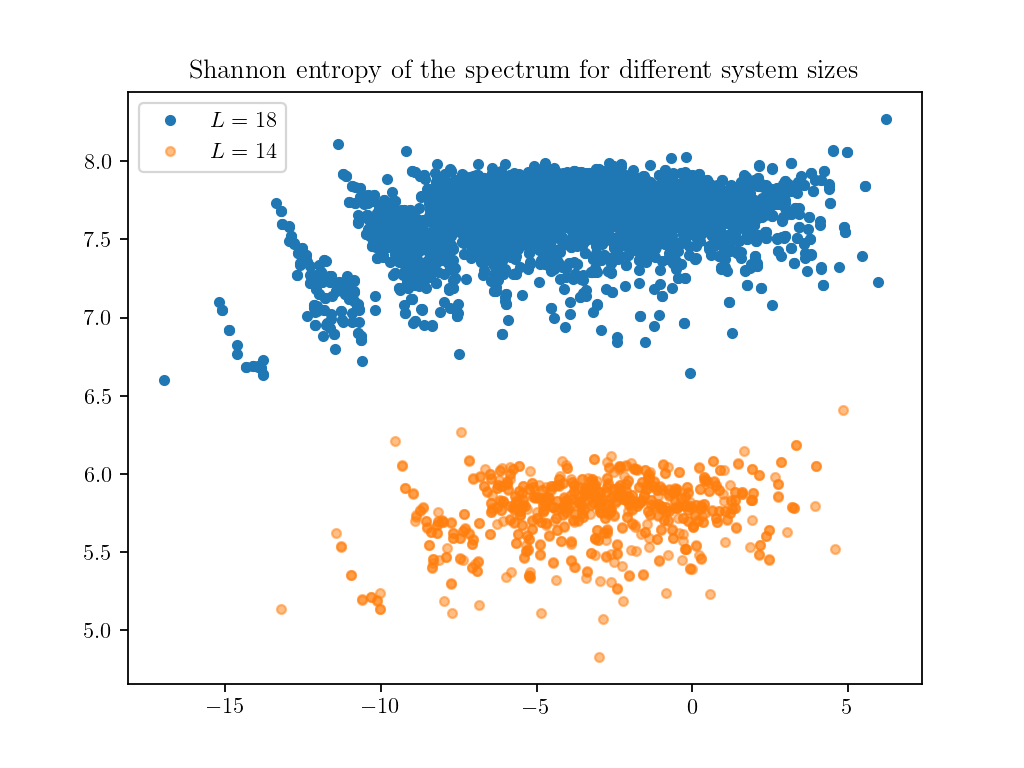

Text(0.5, 1.0, 'Shannon entropy of the spectrum for different system sizes')

In [4]:
sizes=[4,4,4]
alphs=[1.,.5,.2]
la1=0.5
for i,l in enumerate([18,14]):
    file = open('PXP_Z{}_L{}'.format(la1,l), 'rb')
    w=pickle.load(file)
    v=pickle.load(file)
    file.close()
    plot(w,shannon_all(v),'o',ms=sizes[i],label=r'$L={}$'.format(l),alpha=alphs[i])
legend(loc=0)
title('Shannon entropy of the spectrum for different system sizes')

<IPython.core.display.Javascript object>


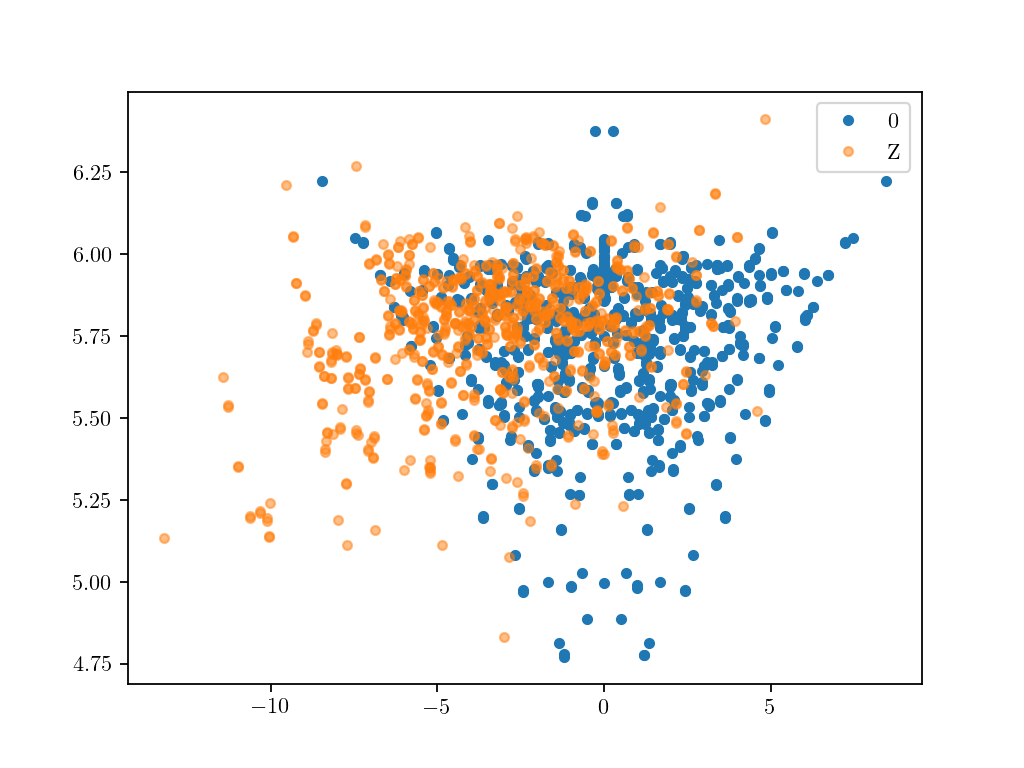

In [5]:
file = open('PXP_red_L14', 'rb')
w=pickle.load(file)
v=pickle.load(file)
file.close()
plot(w,shannon_all(v),'o',ms=sizes[i],label='0')
file = open('PXP_Z0.5_L14', 'rb')
w=pickle.load(file)
v=pickle.load(file)
file.close()
plot(w,shannon_all(v),'o',ms=sizes[i],label='Z',alpha=.5)
legend(loc=0)

In [96]:
file = open('PXP_red_l{la1}_L{l}', 'rb')

In [98]:
pickle.load(file)

EOFError: Ran out of input

In [117]:
wr,vr=eigh(H)

<IPython.core.display.Javascript object>


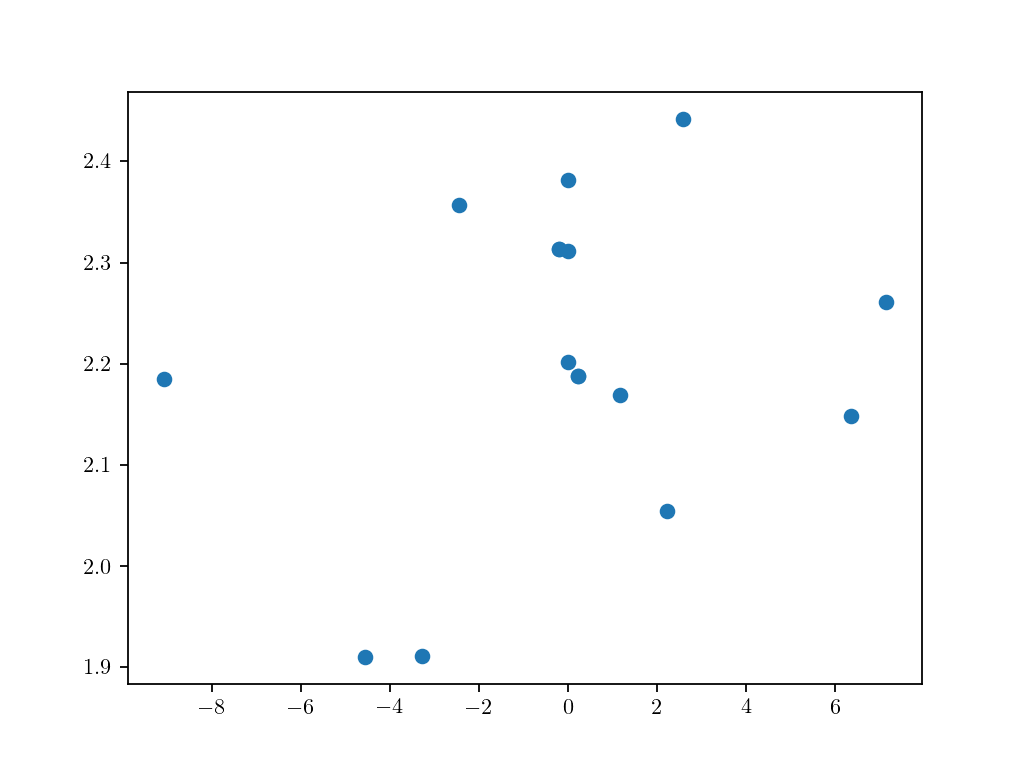

In [118]:
plot(wr,[shannon(vr[:,i]) for i in range(len(w))],'o')

In [119]:
#PXP
L=4
h1=0
h2=zeros((3,3))
h2=h2+transpose(h2)
h3=zeros((3,3,3))
h3[2,0,2]=1
H=Ham(h1,h2,h3,L)

In [120]:
wr,vr=eigh(H)

In [134]:
plot(wr,[shannon(vr[:,i]) for i in range(len(w))],'o')

IndexError: index 16 is out of bounds for axis 1 with size 16

In [35]:
def cost_from_eigen(ws,vs,func):
    q=True
    i_0=0
    i_f=len(ws)
    for i in range(len(ws)):
        if ws[i]>-10 and q:
            q=False
            i_0=i
        if ws[i]>10:
            i_f=i
            break
    sh=[shannon(vs[:,i]) for i in range(i_0,i_f,1)]
    return func(sh)


def cost_h1(harr):
    #h1=harr[0]
    #h2=zeros((3,3))
    #count=1
    #for i in range(3):
    #    for j in range(i,3):
    #        h2[i,j]=harr[count]
    #        h2[j,i]=harr[count]
    #        count+=1
    w,v=eigh(Ham(harr,h2,h3,8))
    
    return cost_from_eigen(w,v,min),cost_from_eigen(w,v,average),cost_from_eigen(w,v,std)

def cost_h2(harr):
    w,v=eigh(Ham(h1,harr*h2,h3,8))
    return cost_from_eigen(w,v,min),cost_from_eigen(w,v,average),cost_from_eigen(w,v,std)

def cost_h3(harr):
    w,v=eigh(Ham(h1,harr*h2,harr*h3,8))
    return cost_from_eigen(w,v,min),cost_from_eigen(w,v,average),cost_from_eigen(w,v,std)

In [127]:
minimize(cost,zeros(1))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1.4044394980627202
        x: [ 0.000e+00]
      nit: 0
      jac: [ 1.976e+07]
 hess_inv: [[1]]
     nfev: 158
     njev: 73

In [22]:
h1=1
h2=zeros((3,3))
h2[0,2]=-1.
h2[2,0]=-1.
h3=zeros((3,3,3))
h3[2,0,2]=1
xx=arange(-2,2,.1)

<IPython.core.display.Javascript object>


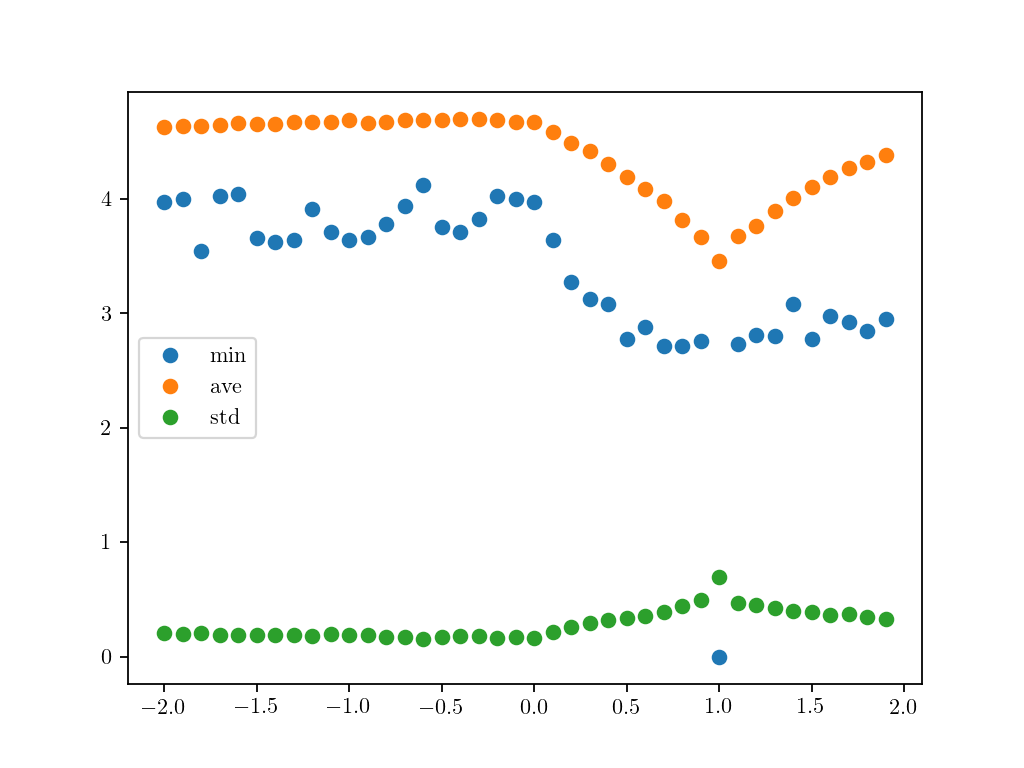

In [29]:
y_min=[]
y_ave=[]
y_std=[]
for x in xx:
    c=cost_h1(x)
    y_min+=[c[0]]
    y_ave+=[c[1]]
    y_std+=[c[2]]
plot(xx,y_min,'o',label='min')
plot(xx,y_ave,'o',label='ave')
plot(xx,y_std,'o',label='std')
legend(loc=0)

In [47]:
y_min=[]
y_ave=[]
y_std=[]
for x in xx:
    c=cost_h2(x)
    y_min+=[c[0]]
    y_ave+=[c[1]]
    y_std+=[c[2]]
plot(xx,y_min,'o',label='min')
plot(xx,y_ave,'o',label='ave')
plot(xx,y_std,'o',label='std')
legend(loc=0)

<IPython.core.display.Javascript object>


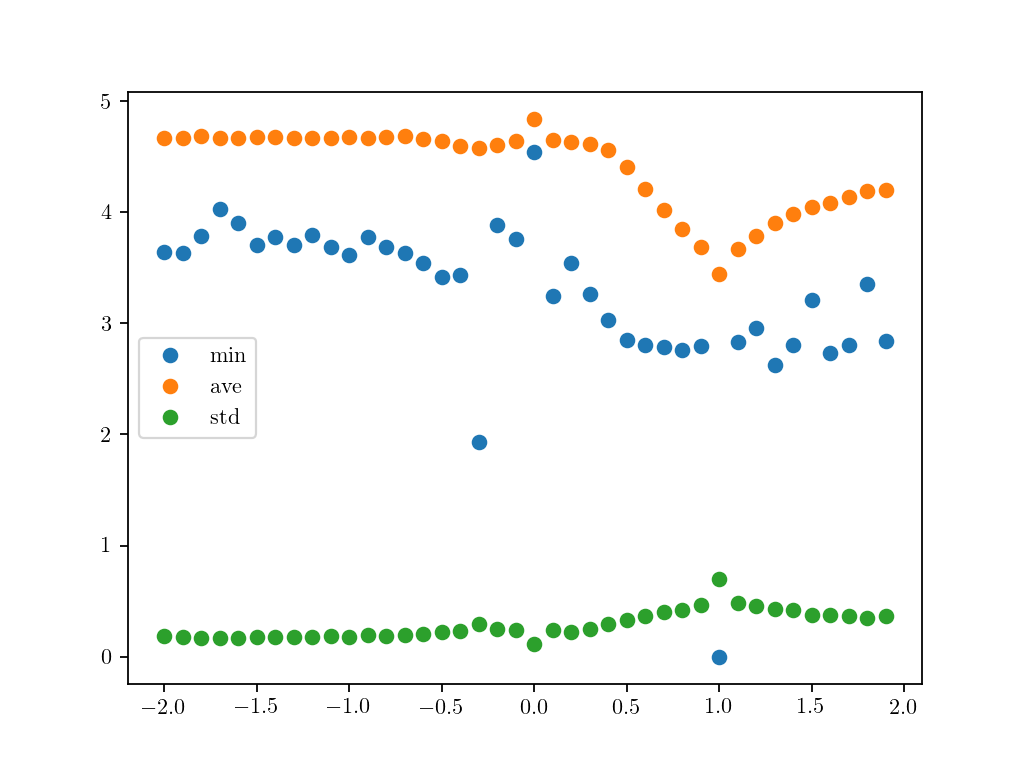

In [36]:
y_min=[]
y_ave=[]
y_std=[]
for x in xx:
    c=cost_h3(x)
    y_min+=[c[0]]
    y_ave+=[c[1]]
    y_std+=[c[2]]
plot(xx,y_min,'o',label='min')
plot(xx,y_ave,'o',label='ave')
plot(xx,y_std,'o',label='std')
legend(loc=0)

In [51]:
#PXP
L=8
h1=1
h2=zeros((3,3))
h2[0,2]=-1.
h2[2,0]=-1.
h3=zeros((3,3,3))
h3[2,0,2]=1
H=Ham(h1,h2,0*h3,L)

In [52]:
w,v=eigh(H)

<IPython.core.display.Javascript object>


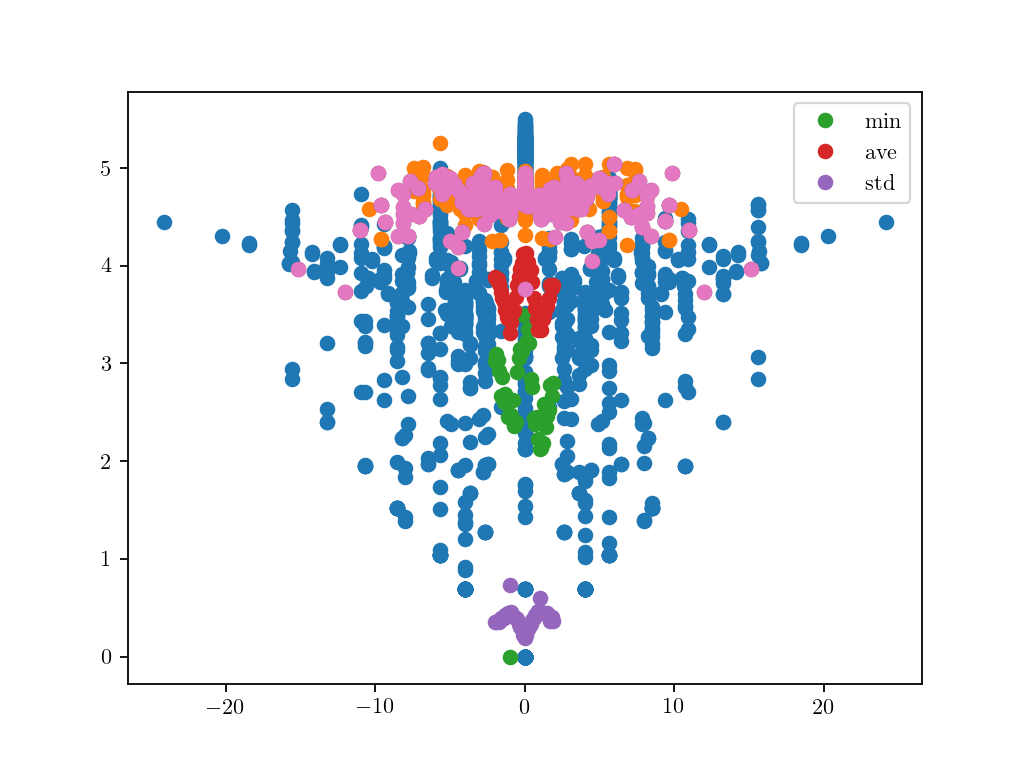

In [42]:
plot(w,[shannon(v[:,i]) for i in range(len(w))],'o')
#plot(range(len(w)),w,'o')

In [53]:
plot(w,[shannon(v[:,i]) for i in range(len(w))],'o')

In [23]:
def fibonacci_word(n):
    a, b = 0, 1
    for i in range(n):
        if b == 0:
            yield 0
            a, b = 0, 1
        else:
            yield 1
            a, b = b, a + b

In [26]:
fibonacci_word(3)

<generator object fibonacci_word at 0x7effe5900270>

In [27]:
for x in fibonacci_word(3):
    print(x)

1
1
1


In [13]:
def valid_states(n):
    zers=['0']
    ones=['1']
    for i in range(n-1):
        new_zers=[]
        new_ones=[]
        for w in zers:
            new_zers+=[w+'0']
            if n>2 and i==n-2 and w[0]=='1':
                continue
            new_ones+=[w+'1']
        for w in ones:
            new_zers+=[w+'0']
        zers,ones=new_zers,new_ones
    return zers+ones

def dics_states(valid_states):
    dic_n2full={}
    dic_full2n={}
    n=0
    for st in valid_states:
        full=int(st,2)
        dic_n2full[n]=full
        dic_full2n[full]=n
        n+=1
    return dic_n2full,dic_full2n

In [14]:
len(valid_states(20))

15127

In [15]:
2**20

1048576

In [69]:
H=HPXP(12)

In [70]:
w,v=eigh(H)

In [71]:
sh=shannon_all(v)

<IPython.core.display.Javascript object>


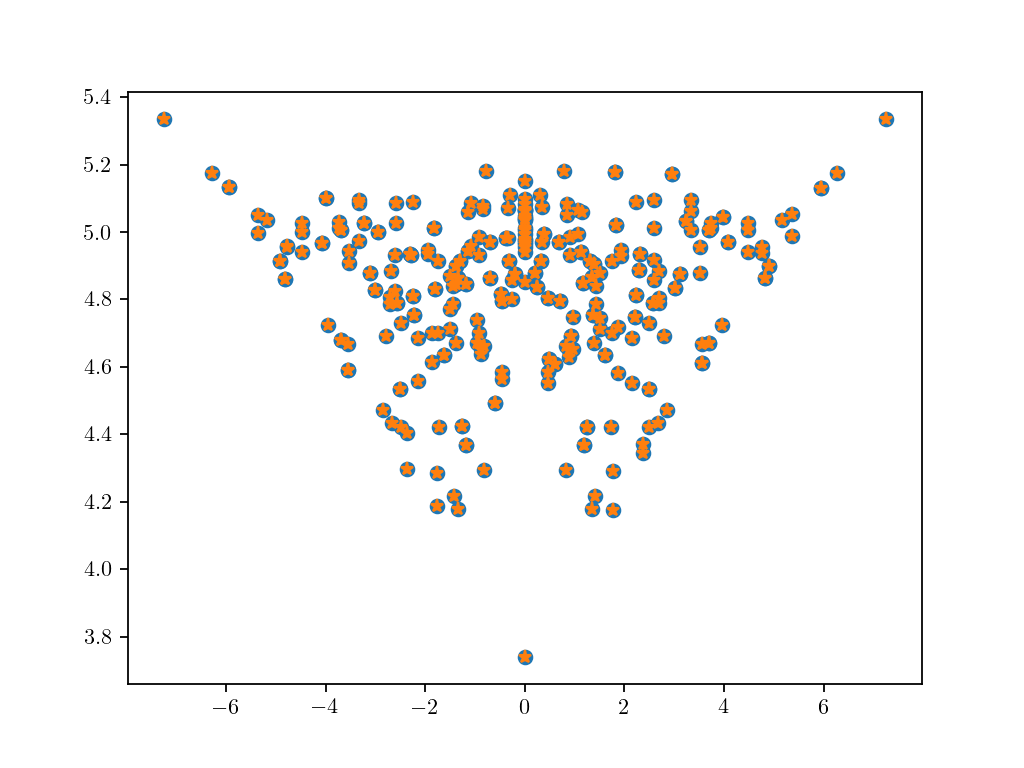

In [72]:
plot(w,sh,'o')

In [73]:
file = open('PXP_red_L12', 'rb')
w=pickle.load(file)
v=pickle.load(file)
file.close()
plot(w/4,[shannon(v[:,i]) for i in range(len(w))],'*')

In [26]:
len(H)

2207

In [1]:
hist(w,bins=201);

In [44]:
len(HPXP(22))

MemoryError: Unable to allocate 23.4 GiB for an array with shape (39603, 39603) and data type complex128

In [90]:
'asddasasdasd'.count('a')

4

In [6]:
#Building blocks for 1, 2 and 3 neighboring spin interactions

#One spin terms look like h1[i]pauli[i]
def buildingb1(h1):
    bb=zeros((2,2),complex)
    for i in range(3):
        bb+=h1[i]*pauli[i+1]
    return bb

#Two spin terms look like h2[i,j]pauli[i]pauli[j]
def buildingb2(h2):
    bb=zeros((4,4),complex)
    for i1 in range(3):
        for i2 in range(3):
            bb+=h2[i1,i2]*kron(pauli[i1+1],pauli[i2+1])
    return bb

#Three spin terms look like h3[i,j,k]pauli[i]pauli[j]pauli[k]
def buildingb3(h3):
    bb=zeros((8,8),complex)
    for i1 in range(3):
        for i2 in range(3):
            for i3 in range(3):
                bb+=h3[i1,i2,i3]*kron(pauli[i1+1],kron(pauli[i2+1],pauli[i3+1]))
    return bb

#Two spin terms across the boundary (PBC)
def lastpiece2(h2,L):
    hh=zeros((2**L,2**L),complex)
    for i1 in range(3):
        for i2 in range(3):
            hh+=h2[i1,i2]*kron(kron(pauli[i2+1],identity(2**(L-2))),pauli[i1+1])
    return hh

#Three spin terms across the boundary (PBC)
def lastpiece3(h3,L):
    hh=zeros((2**L,2**L),complex)
    for i1 in range(3):
        for i2 in range(3):
            for i3 in range(3):
                hh+=h3[i1,i2,i3]*kron(kron(pauli[i3+1],identity(2**(L-3))),kron(pauli[i1+1],pauli[i2+1]))
                hh+=h3[i1,i2,i3]*kron(kron(pauli[i2+1],pauli[i3+1]),kron(identity(2**(L-3)),pauli[i1+1]))
    return hh

def Ham(h1,h2,h3,L):
    H0=zeros((2**L,2**L),complex)
    bb2=buildingb2(h2)
    bb3=buildingb3(h3)
    for i in range(L-2):
        I0=identity(2**i)
        H0+=h1*kron(kron(I0,p1),identity(2**(L-i-1)))
        H0+=kron(kron(I0,bb2),identity(2**(L-i-2)))
        H0+=kron(kron(I0,bb3),identity(2**(L-i-3)))
    i=L-2
    I0=identity(2**i)
    H0+=h1*kron(kron(I0,p1),identity(2**(L-i-1)))
    H0+=kron(kron(I0,bb2),identity(2**(L-i-2)))
    i=L-1
    I0=identity(2**i)
    H0+=h1*kron(kron(I0,p1),identity(2**(L-i-1)))
    H0+=lastpiece2(h2,L)+lastpiece3(h3,L)
    return H0

#Constructing the Hamiltonian from the building blocks
def Ham_bb(h1,h2,h3,L):
    H0=zeros((2**L,2**L),complex)
    bb1=buildingb1(h1)
    bb2=buildingb2(h2)
    bb3=buildingb3(h3)
    for i in range(L-2):
        I0=identity(2**i)
        H0+=kron(kron(I0,bb1),identity(2**(L-i-1)))
        H0+=kron(kron(I0,bb2),identity(2**(L-i-2)))
        H0+=kron(kron(I0,bb3),identity(2**(L-i-3)))
    i=L-2
    I0=identity(2**i)
    H0+=kron(kron(I0,bb1),identity(2**(L-i-1)))
    H0+=kron(kron(I0,bb2),identity(2**(L-i-2)))
    i=L-1
    I0=identity(2**i)
    H0+=kron(kron(I0,bb1),identity(2**(L-i-1)))
    H0+=lastpiece2(h2,L)+lastpiece3(h3,L)
    return H0


# Constructing the Hamiltonian by looking through all the states and consider only valid ones

In [ ]:
def verify_PXP_state(st_string,L):
    ln=len(st_string)
    valid=True
    if ln==1:
        return True
    for i in range(ln-1):
        if st_string[i]+st_string[i+1]=='11':
            valid=False
            break
    if ln==L:
        valid = valid and (not st_string[-1]+st_string[0]=='11')
    return valid

def Ham_reduce_PXP(H):
    N=len(H)
    L=round(log(N)/log(2))
    states=[]
    for n in range(N):
        #Verifies if a state is valid and then construct it
        if verify_PXP_state(bin(n)[2:],L):
            states+=[zeros(N)]
            states[-1][N-n-1]=1
    Nef=len(states)
    newH=zeros((Nef,Nef),complex)
    for i,st1 in enumerate(states):
        st_prime=dot(H,st1)
        for j,st2 in enumerate(states):
            newH[j,i]=dot(st2,st_prime)
    return newH

## Results for the PXP Model

In [4]:
#PXP
h01=array([1.,0,0])
h02=zeros((3,3))
h02[0,2]=-1.
h02[2,0]=-1.
h03=zeros((3,3,3))
h03[2,0,2]=1

### Including all states

In [7]:
for i,l in enumerate([12,10,8]):
    H=Ham_bb(h01,h02,h03,l)
    w,v=eigh(H)
    file = open('PXP_L{}'.format(l), 'wb')
    pickle.dump(w,file)
    pickle.dump(v,file)
    file.close()

<IPython.core.display.Javascript object>


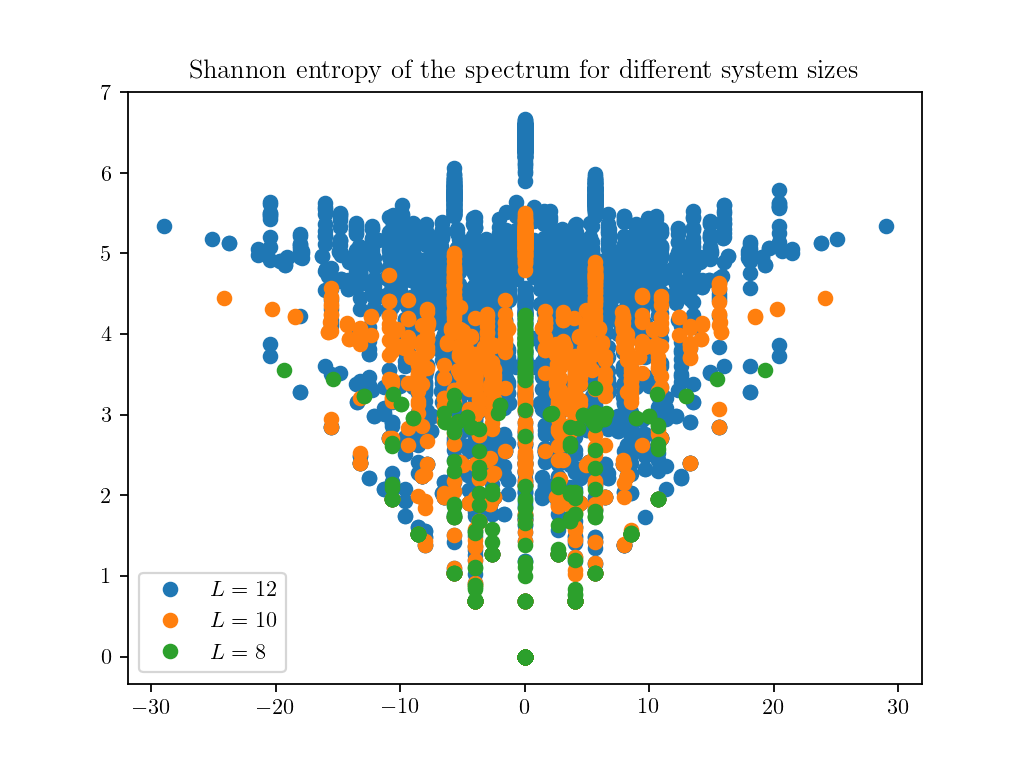

Text(0.5, 1.0, 'Shannon entropy of the spectrum for different system sizes')

In [74]:
for i,l in enumerate([12,10,8]):
    file = open('PXP_L{}'.format(l), 'rb')
    w=pickle.load(file)
    v=pickle.load(file)
    file.close()
    plot(w,shannon_all(v),'o',label=r'$L={}$'.format(l))
legend(loc=0)
title('Shannon entropy of the spectrum for different system sizes')

### Considering only valid states

In [8]:
#for i,l in enumerate([18,16,14]):
#    H=HPXP(l)
#    w,v=eigh(H)
#    file = open('PXP_red_L{}'.format(l), 'wb')
#    pickle.dump(w,file)
#    pickle.dump(v,file)
#    file.close()
data={}
for i,l in enumerate([18,16,14]):
    data[l]={}
    file = open('PXP_red_L{}'.format(l), 'rb')
    data[l]['w'] = pickle.load(file)
    data[l]['v'] = pickle.load(file)
    file.close()

<IPython.core.display.Javascript object>


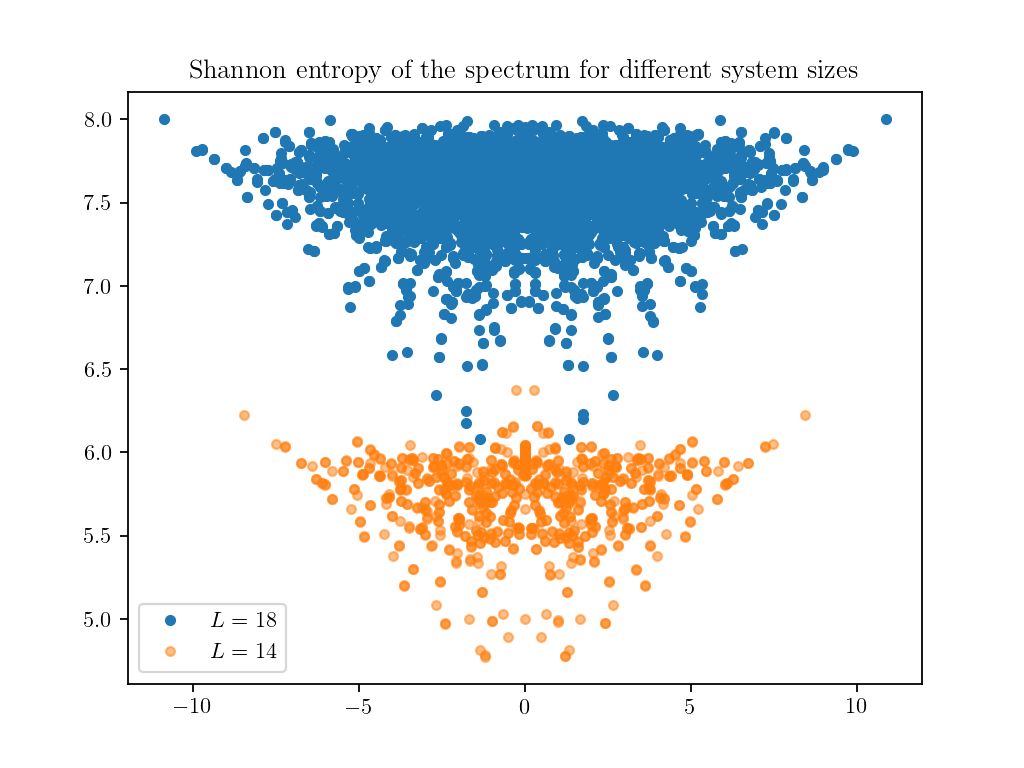

Text(0.5, 1.0, 'Shannon entropy of the spectrum for different system sizes')

In [81]:
sizes=[4,4,4]
alphs=[1.,.5,.2]
for i,l in enumerate([18,14]):
    file = open('PXP_red_L{}'.format(l), 'rb')
    w=pickle.load(file)
    v=pickle.load(file)
    file.close()
    plot(w,shannon_all(v),'o',ms=sizes[i],label=r'$L={}$'.format(l),alpha=alphs[i])
legend(loc=0)
title('Shannon entropy of the spectrum for different system sizes')

#### Mode Distribution

<IPython.core.display.Javascript object>


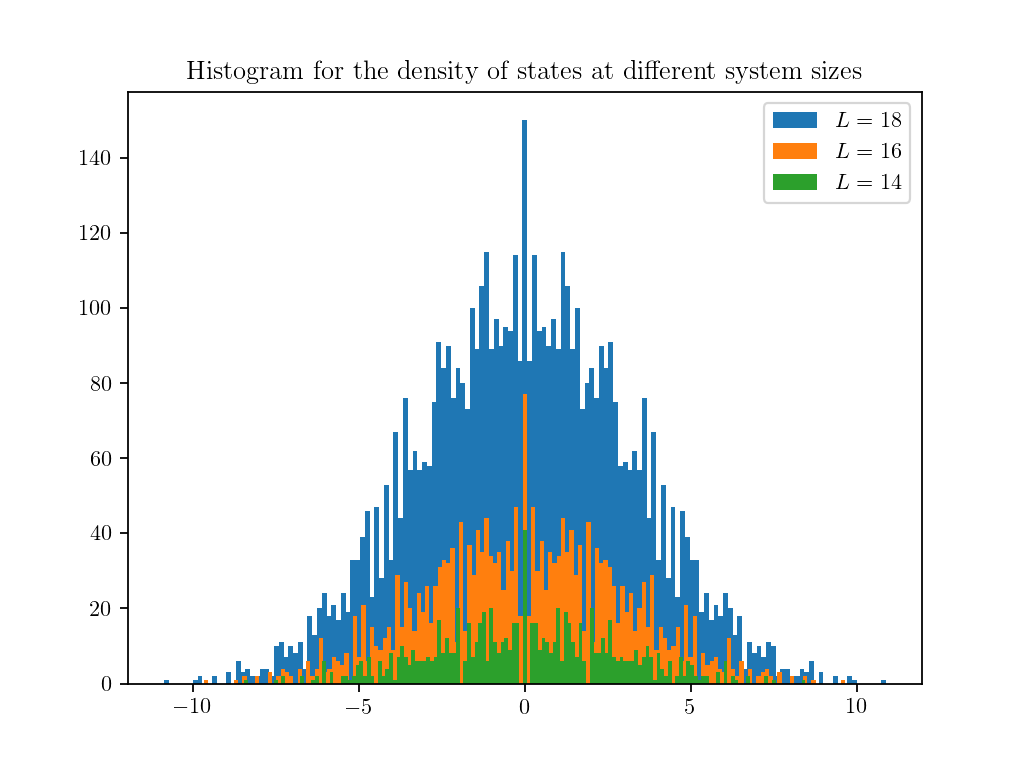

In [88]:
for i,l in enumerate([18,16,14]):
    file = open('PXP_red_L{}'.format(l), 'rb')
    w=pickle.load(file)
    v=pickle.load(file)
    file.close()
    hist(w,bins=151,label=r'$L={}$'.format(l))
title('Histogram for the density of states at different system sizes')
legend(loc=0)

#### Level Distribution

<IPython.core.display.Javascript object>


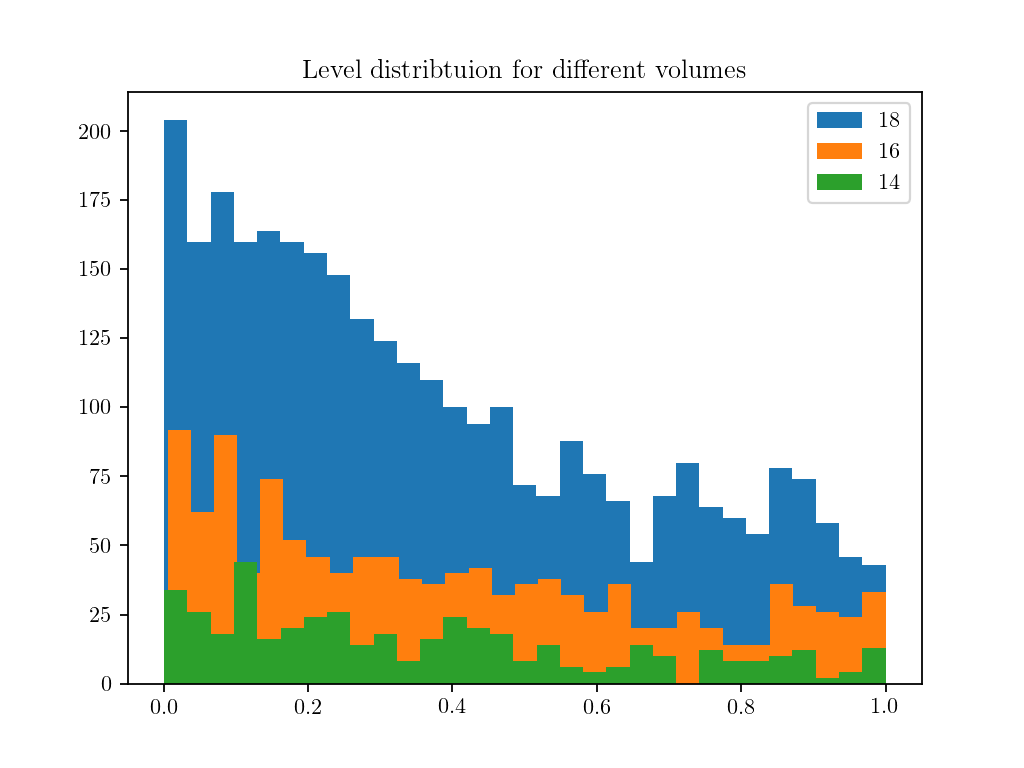

In [13]:
for i,l in enumerate([18,16,14]):
    file = open('PXP_red_L{}'.format(l), 'rb')
    w=pickle.load(file)
    v=pickle.load(file)
    file.close()
    N=len(w)
    yy=[]
    s0=w[1]-w[0]
    for i in range(1,N-1):
        s=w[i+1]-w[i]
        if abs(s)<.0000001 or abs(s0)<.0000001:
            continue
        r=s/s0
        yy+=[min(r,1/r)]
        s0=s
    hist(yy,31,label=l)
title('Level distribtuion for different volumes')
legend(loc=0)

<IPython.core.display.Javascript object>


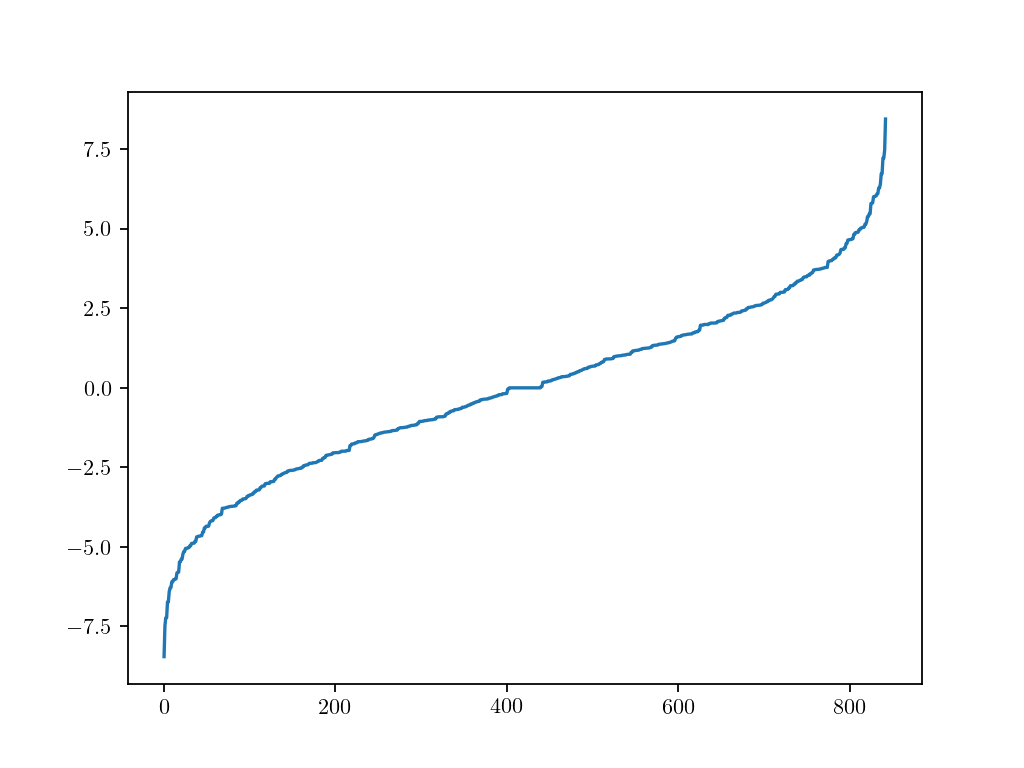

In [14]:
file = open('PXP_red_L{}'.format(l), 'rb')
w=pickle.load(file)
v=pickle.load(file)
plot(range(len(w)),w)

#### Entanglement Entropy (unfinished)

In [12]:
st=data[14]['v'][:,0]

In [13]:
states=valid_states(14)
dic_n2full,dic_full2n=dics_states(states)

In [41]:
states_2=valid_states(7,pbc=False)
half_n2full,half_full2n=dics_states(states_2)

In [44]:
yy=[]
for i in range(len(data[14]['v'])):
    r0=time()
    st=data[14]['v'][:,i]
    rho=reduced_matrix(st,14,dic_n2full,dic_full2n,half_n2full,half_full2n)
    yy+=[entropy(rho)]
    print(i,time()-r0)

0 2.8642516136169434
1 2.924534320831299
2 2.907597303390503
3 2.885087013244629
4 3.0095767974853516
5 2.8841636180877686
6 3.411388874053955
7 3.439011573791504
8 3.221961259841919
9 2.806791305541992
10 3.0089211463928223
11 3.5436577796936035
12 3.768493413925171
13 3.554387092590332
14 3.428654909133911
15 3.466550350189209
16 3.466763496398926
17 3.631314754486084
18 3.470750331878662
19 3.461948871612549
20 3.532496452331543
21 3.5896799564361572
22 3.848656415939331
23 3.084846019744873


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


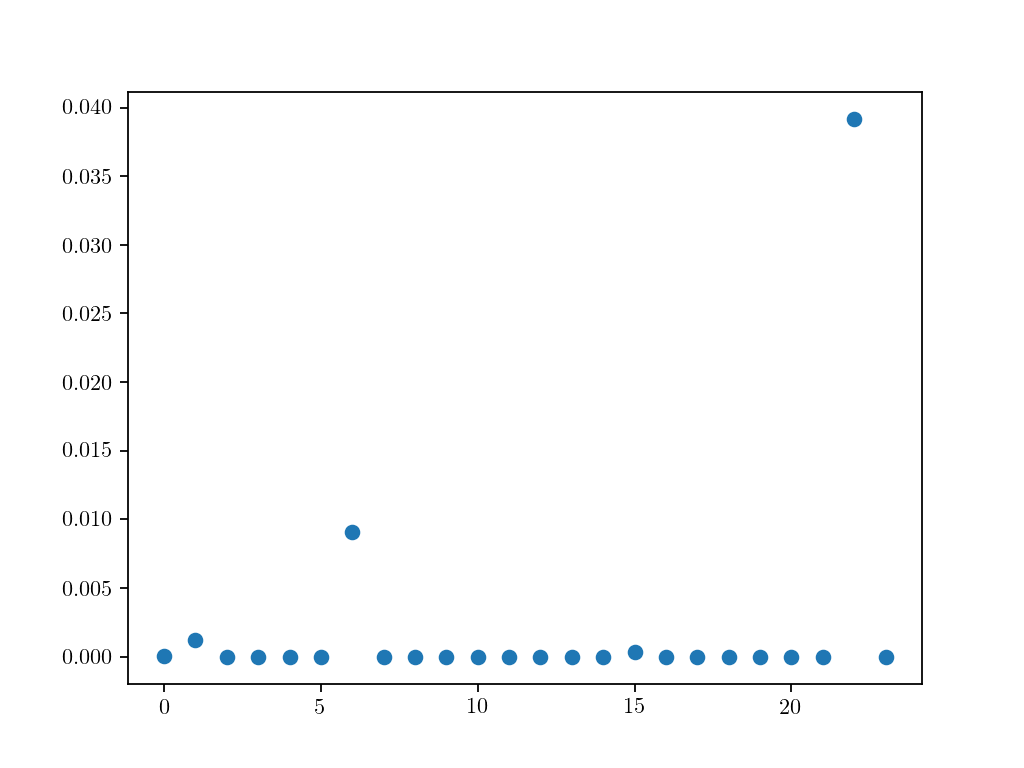

In [45]:
plot(range(len(yy)),yy,'o')

# Constructing the Hamiltonian through valid building blocks

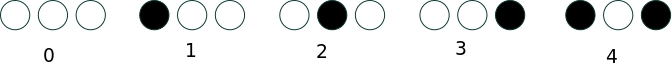

In [7]:
def valid_states(L,pbc=True):
    lst0=[zeros(L,int)]
    lst1=[zeros(L,int)]
    lst1[0][0]=1
    for i in range(1,L-1):
        lst0+=lst1
        lst1=[]
        new=[]
        for s in lst0:
            if s[i-1]==0:
                st=deepcopy(s)
                st[i]=1
                new+=[st]
        lst0+=lst1
        lst1=deepcopy(new)
    lst0+=lst1
    lst1=[]
    for s in lst0:
        if s[0]==0 and s[-2]==0:
            st=deepcopy(s)
            st[-1]=1
            lst1+=[st]
    return lst0+lst1

def build_st_dicitonaries(valid_states):
    m2M={}
    M2m={}
    for m,st in enumerate(valid_states):
        M=int(''.join(map(str,st)))
        m2M[m]=M
        M2m[M]=m
    return m2M,M2m

def Hpxp(L,valid_states,M2m):
    N=len(valid_states)
    H=zeros((N,N),complex)
    for m1,st in enumerate(valid_states):
        for i in range(L):
            if st[(i-1)%L]==0 and st[(i+1)%L]==0:
                new_st=deepcopy(st)
                new_st[i]=1-st[i]
                M=int(''.join(map(str,new_st)))
                m2=M2m[M]
                H[m2,m1]=1
    return H

In [4]:
L=18

In [5]:
va_sts=valid_states(L)
m2M,M2m=build_st_dicitonaries(va_sts)
H=Hpxp(L,va_sts,M2m)
print(len(va_sts))

5778


In [6]:
#Identify 010101010101
M=int(''.join(map(str,'01'*(L//2))))
z2=M2m[M]
print(z2)

5777


In [7]:
w,v=eigh(H)

In [8]:
sh=[shannon_st(v[:,i]) for i in range(len(v))]

<IPython.core.display.Javascript object>


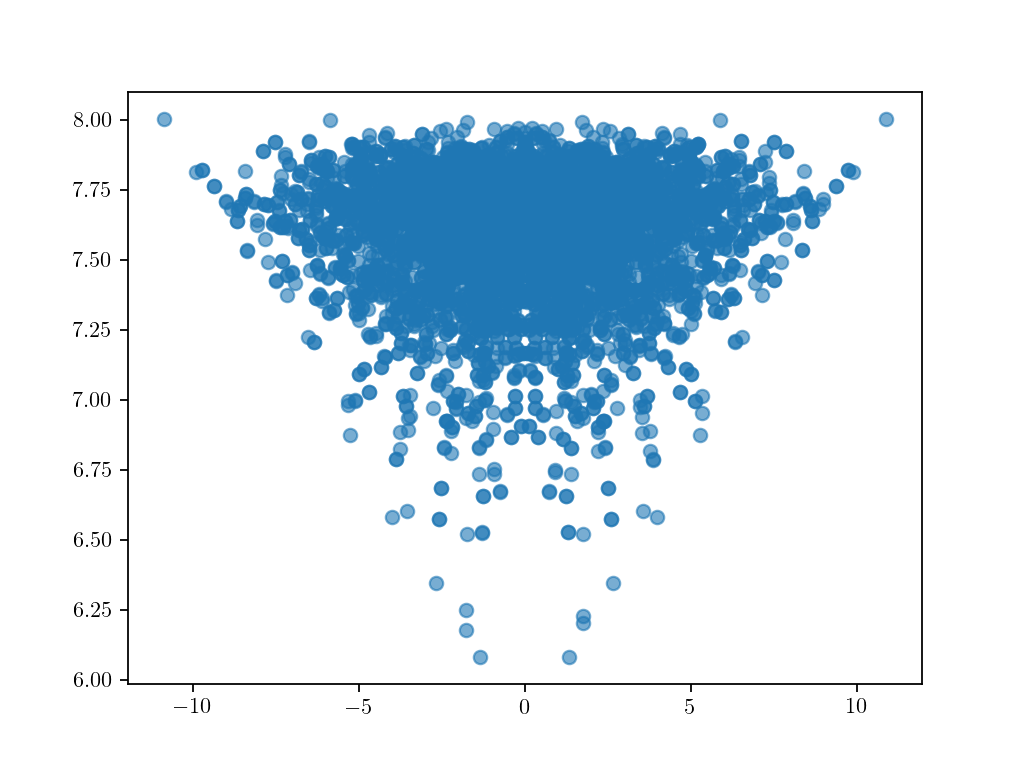

In [9]:
plot(w,sh,'o',alpha=.6)

In [10]:
z2_comp=[abs(v[:,i][z2]+10**(-5))**2 for i in range(len(v))]

<IPython.core.display.Javascript object>


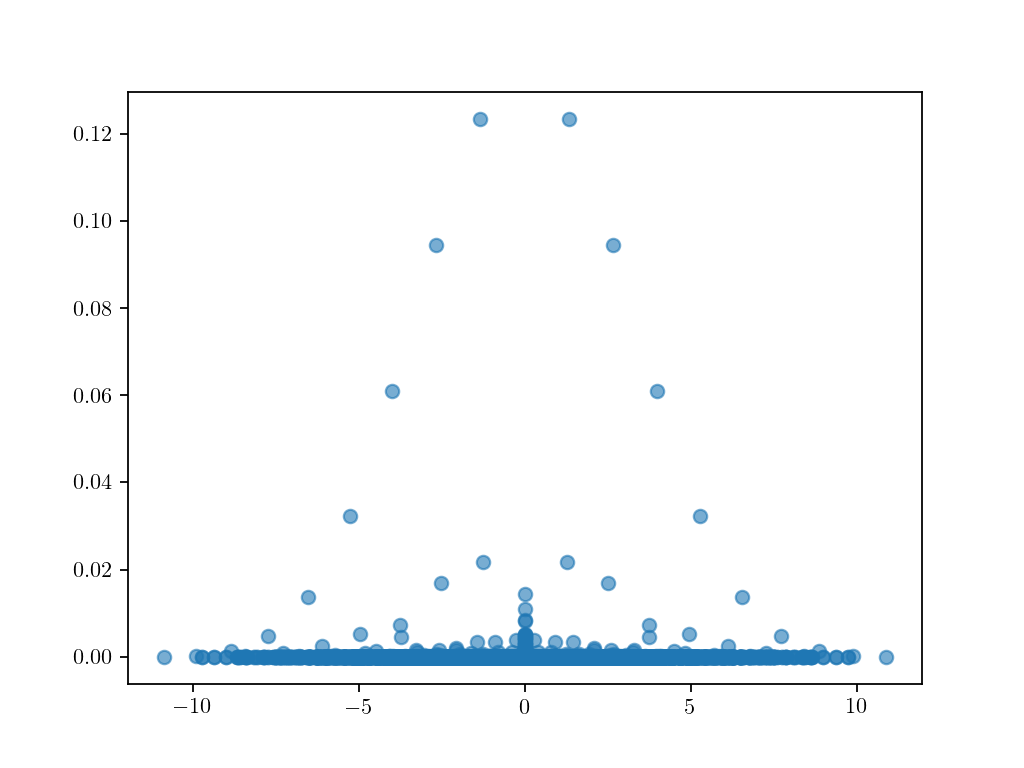

In [11]:
plot(w,z2_comp,'o',alpha=.6)

In [23]:
f=open('shannon_z2comp_L20.csv','w')
f.write('E,S,z2log\n')
for i in range(len(w)):
    f.write('{},{},{}\n'.format(w[i],sh[i],z2_comp[i]))
f.close()

In [24]:
file = open('eigens20', 'wb')
pickle.dump(w,file)
pickle.dump(v,file)
file.close()
#file = open('gap8x2','rb')
#rk=pickle.load(file)
#si=pickle.load(file)
#file.close()

In [42]:
f=read_csv('shannon_L10.csv')

<IPython.core.display.Javascript object>


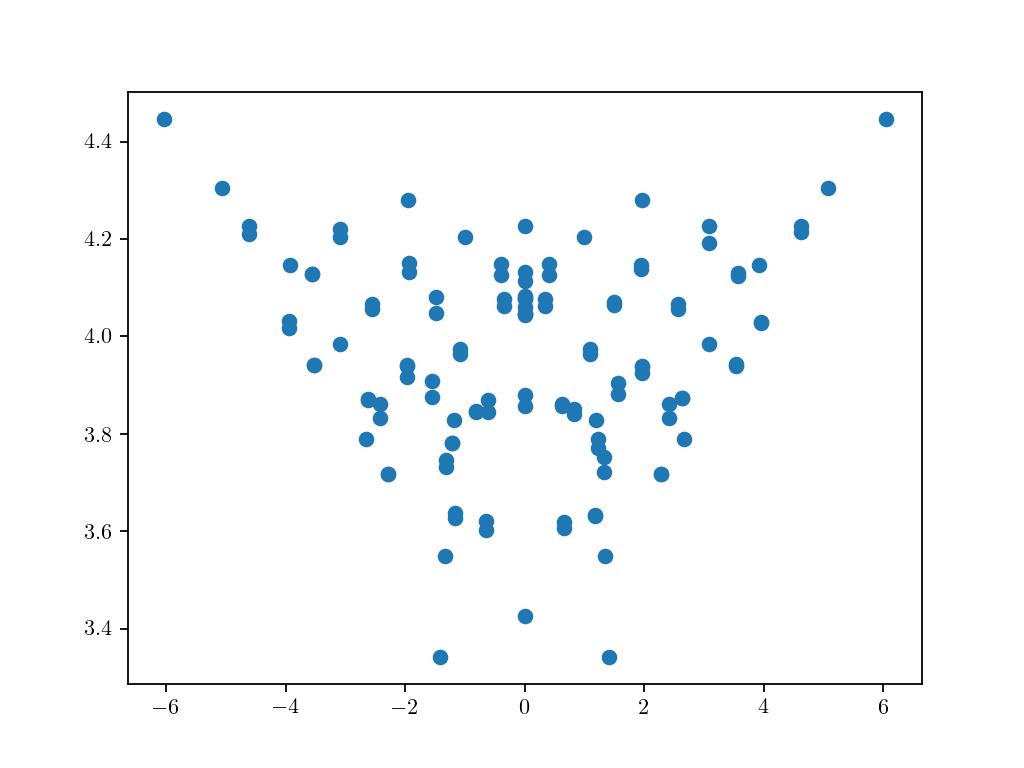

In [43]:
plot(f['E'],f['S'],'o')

<IPython.core.display.Javascript object>


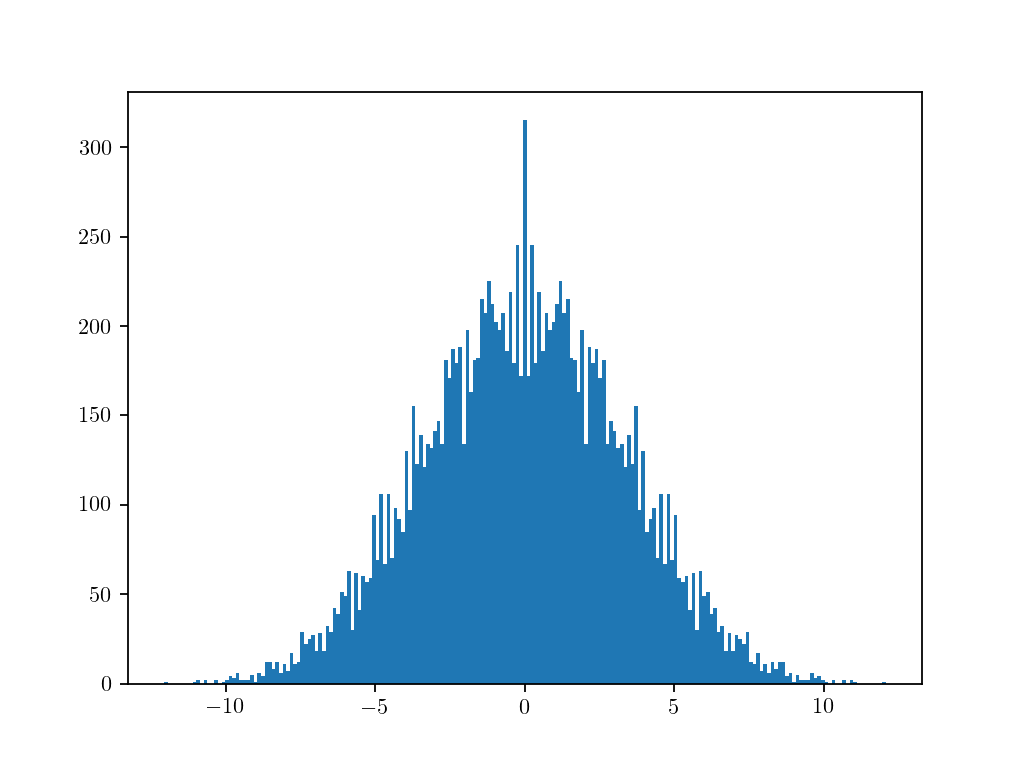

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,   0.,
          2.,   0.,   0.,   2.,   0.,   1.,   2.,   4.,   3.,   6.,   2.,
          2.,   2.,   5.,   1.,   6.,   4.,  12.,  12.,   8.,  12.,   6.,
         11.,   7.,  17.,  11.,  12.,  29.,  22.,  25.,  27.,  18.,  28.,
         18.,  32.,  29.,  42.,  39.,  51.,  49.,  63.,  30.,  62.,  41.,
         60.,  57.,  59.,  94.,  69., 106.,  67., 106.,  70.,  98.,  92.,
         85., 130.,  97., 155., 123., 139., 121., 134., 132., 141., 147.,
        134., 181., 171., 187., 179., 188., 134., 198., 163., 181., 182.,
        215., 207., 225., 212., 202., 198., 207., 186., 219., 179., 245.,
        172., 315., 172., 245., 179., 219., 186., 207., 198., 202., 212.,
        225., 207., 215., 182., 181., 163., 198., 134., 188., 179., 187.,
        171., 181., 134., 147., 141., 132., 134., 121., 139., 123., 155.,
         97., 130.,  85.,  92.,  98.,  70., 106.,  67., 106.,  69.,  94.,
         59.,  57.,  60.,  41.,  62., 

In [27]:
hist(w,bins=201)

<IPython.core.display.Javascript object>


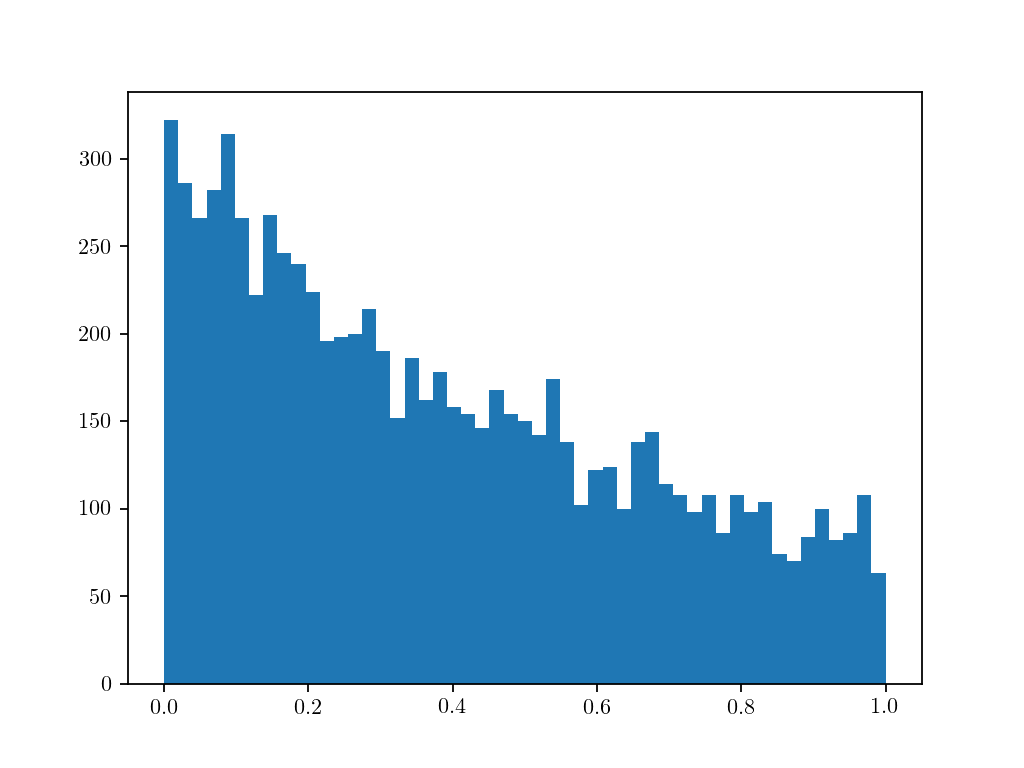

(array([322., 286., 266., 282., 314., 266., 222., 268., 246., 240., 224.,
        196., 198., 200., 214., 190., 152., 186., 162., 178., 158., 154.,
        146., 168., 154., 150., 142., 174., 138., 102., 122., 124., 100.,
        138., 144., 114., 108.,  98., 108.,  86., 108.,  98., 104.,  74.,
         70.,  84., 100.,  82.,  86., 108.,  63.]),
 array([1.81258943e-04, 1.97855480e-02, 3.93898370e-02, 5.89941261e-02,
        7.85984151e-02, 9.82027041e-02, 1.17806993e-01, 1.37411282e-01,
        1.57015571e-01, 1.76619860e-01, 1.96224149e-01, 2.15828438e-01,
        2.35432727e-01, 2.55037016e-01, 2.74641306e-01, 2.94245595e-01,
        3.13849884e-01, 3.33454173e-01, 3.53058462e-01, 3.72662751e-01,
        3.92267040e-01, 4.11871329e-01, 4.31475618e-01, 4.51079907e-01,
        4.70684196e-01, 4.90288485e-01, 5.09892774e-01, 5.29497063e-01,
        5.49101352e-01, 5.68705641e-01, 5.88309930e-01, 6.07914219e-01,
        6.27518508e-01, 6.47122797e-01, 6.66727086e-01, 6.86331375e-01,
    

In [30]:
N=len(w)
yy=[]
s0=w[1]-w[0]
for i in range(1,N-1):
    s=w[i+1]-w[i]
    if abs(s)<.0000001 or abs(s0)<.0000001:
        continue
    r=s/s0
    yy+=[min(r,1/r)]
    s0=s
hist(yy,51)

In [4]:
L=18

va_sts=valid_states(L)
m2M,M2m=build_st_dicitonaries(va_sts)
H=Hpxp(L,va_sts,M2m)
print(len(va_sts))

5778


In [13]:
Obs=zeros((len(va_sts),len(va_sts)))
for i,st in enumerate(va_sts):
    Obs[i,i]=(2*sum(st)-L)/L

In [107]:
va_sts[1294]

array([1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0])

In [6]:
dt=.1
U=expm(-1.j*dt*H)

In [80]:
for ind in [6]:
    v0=zeros(len(U),complex)
    v0[ind]=1.
    xx=[0]
    yy6=[dot(v0,dot(Obs,v0))]
    for i in range(200):
        xx+=[i*dt]
        v0=dot(U,v0)
        yy6+=[real(dot(conjugate(v0),dot(Obs,v0)))]
    plot(xx,yy6,'-',alpha=.8)

<IPython.core.display.Javascript object>


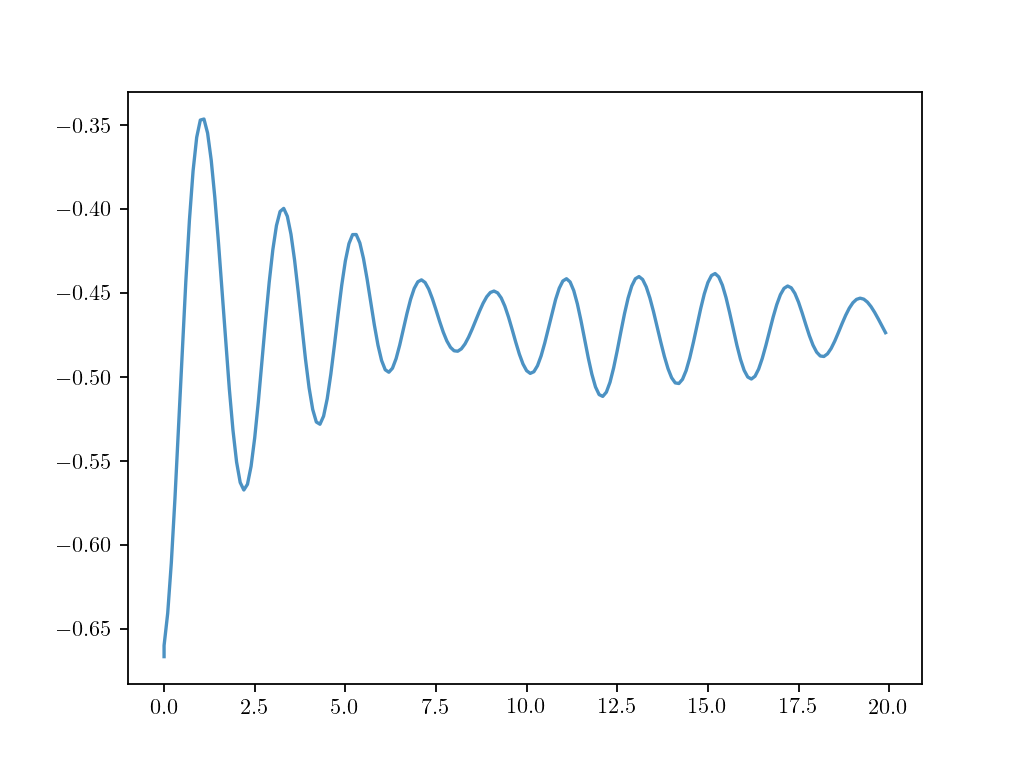

In [85]:
for ind in [111]:
    v0=zeros(len(U),complex)
    v0[ind]=1.
    xx=[0]
    yy111=[dot(v0,dot(Obs,v0))]
    for i in range(200):
        xx+=[i*dt]
        v0=dot(U,v0)
        yy111+=[real(dot(conjugate(v0),dot(Obs,v0)))]
    plot(xx,yy111,'-',alpha=.8)

In [88]:
for ind in [1294]:
    v0=zeros(len(U),complex)
    v0[ind]=1.
    xx=[0]
    yy1294=[dot(v0,dot(Obs,v0))]
    for i in range(200):
        xx+=[i*dt]
        v0=dot(U,v0)
        yy1294+=[real(dot(conjugate(v0),dot(Obs,v0)))]
    #plot(xx,yy323,'-',alpha=.8)

In [90]:
for ind in [-1]:
    v0=zeros(len(U),complex)
    v0[ind]=1.
    xx=[0]
    yym=[dot(v0,dot(Obs,v0))]
    for i in range(200):
        xx+=[i*dt]
        v0=dot(U,v0)
        yym+=[real(dot(conjugate(v0),dot(Obs,v0)))]

<IPython.core.display.Javascript object>


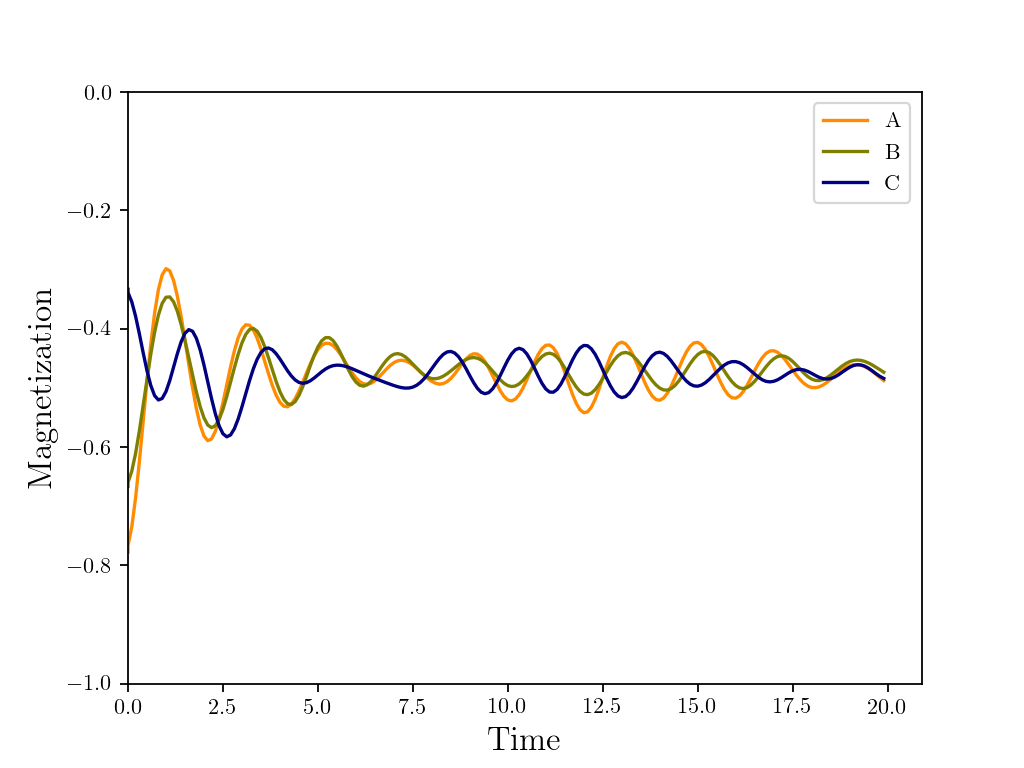

/home/joao/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [102]:
plot(xx,yy6,'-',ms=10,alpha=1,label='A',color='darkorange')
plot(xx,yy111,'-',ms=10,alpha=1,label='B',color='olive')
plot(xx,yy1294,'-',ms=10,alpha=1,label='C',color='navy')
ylim(-1,0)
xlim(left=0)
ylabel('Magnetization',size=15)
xlabel('Time',size=15)
legend(loc=0)
savefig('thermal.png',dpi=300)

<IPython.core.display.Javascript object>


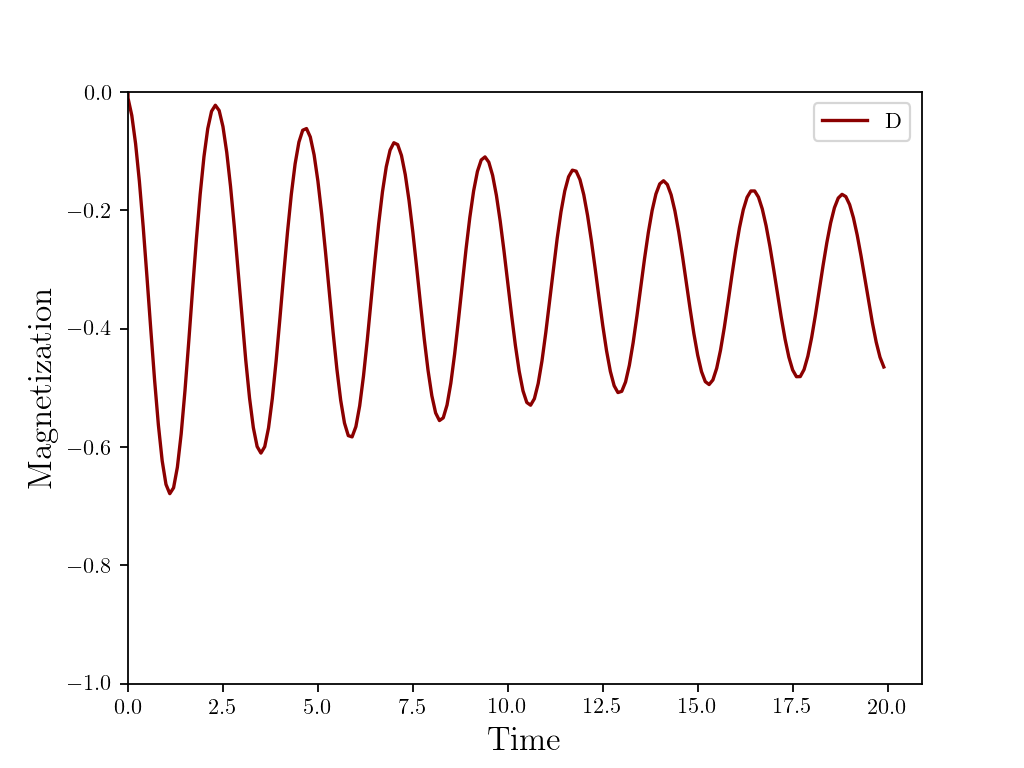

In [103]:
plot(xx,yym,'-',ms=10,alpha=1,label='D',color='darkred')
ylim(-1,0)
xlim(left=0)
ylabel('Magnetization',size=15)
xlabel('Time',size=15)
legend(loc=0)
savefig('scar.png',dpi=300)

<IPython.core.display.Javascript object>


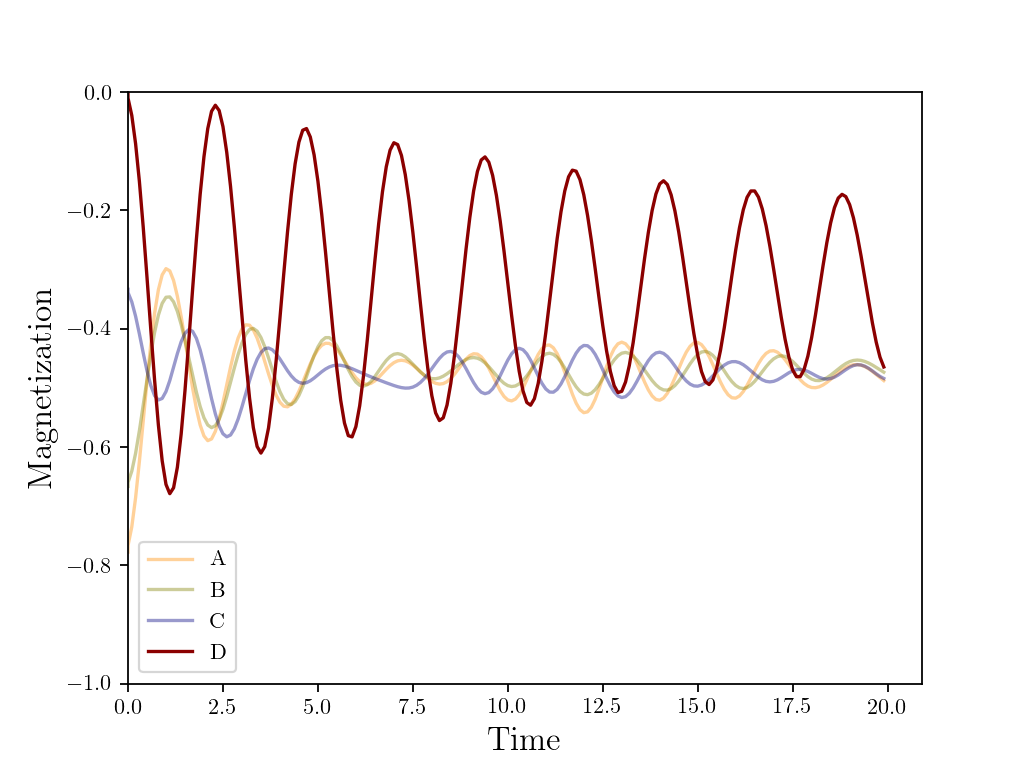

In [104]:
plot(xx,yy6,'-',ms=10,alpha=.4,label='A',color='darkorange')
plot(xx,yy111,'-',ms=10,alpha=.4,label='B',color='olive')
plot(xx,yy1294,'-',ms=10,alpha=.4,label='C',color='navy')
plot(xx,yym,'-',ms=20,alpha=1,label='D',color='darkred')
ylim(-1,0)
xlim(left=0)
ylabel('Magnetization',size=15)
xlabel('Time',size=15)
legend(loc=0)
savefig('thermal_scar.png',dpi=300)

In [48]:
w,v=eigh(H)

<IPython.core.display.Javascript object>


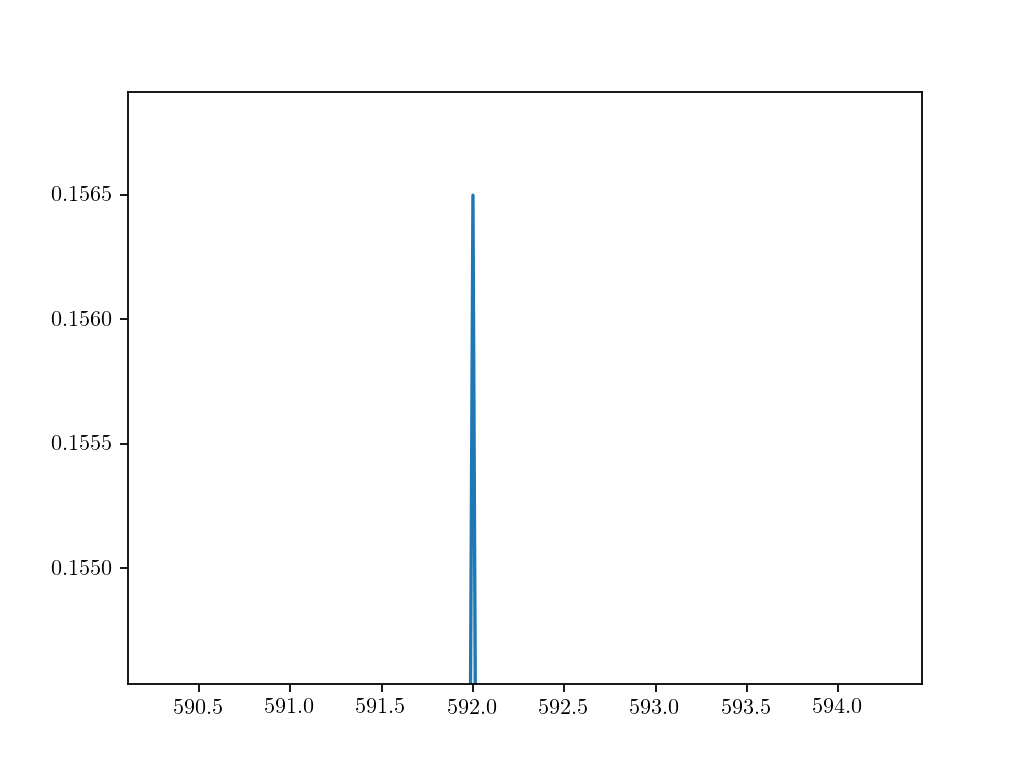

In [50]:
plot(range(len(w)),abs(v[-1,:]))

<IPython.core.display.Javascript object>


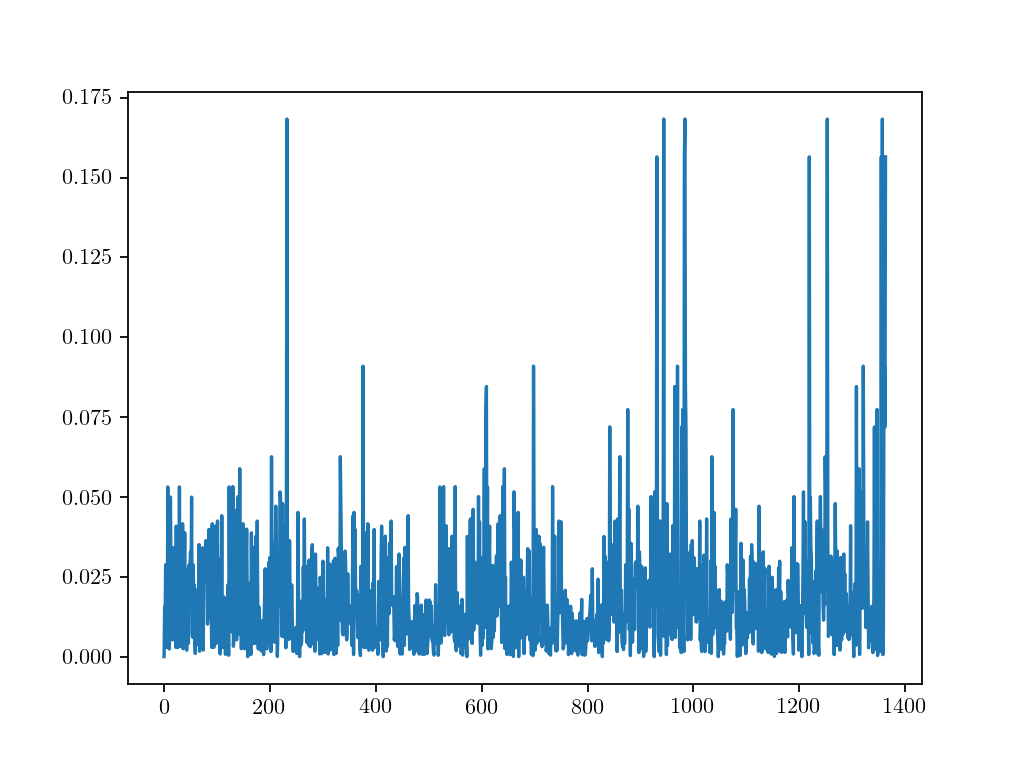

In [51]:
plot(range(len(w)),abs(v[:,592]))

In [33]:
sh=[shannon_st(v[:,i]) for i in range(len(v))]

<IPython.core.display.Javascript object>


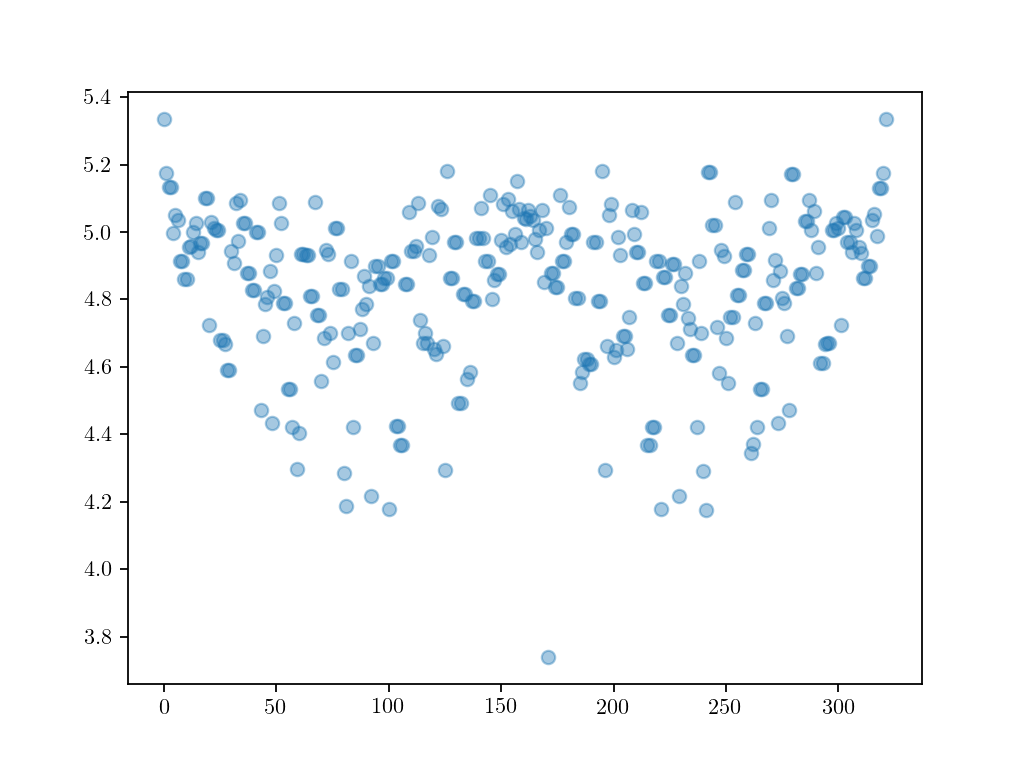

In [35]:
plot(range(len(w)),sh,'o',alpha=.4)

## Exitations

In [3]:
L=18

In [8]:
va_sts=valid_states(L)
m2M,M2m=build_st_dicitonaries(va_sts)
H=Hpxp(L,va_sts,M2m)
print(len(va_sts))

5778


In [41]:
mks=['o','h','*','s']

In [9]:
w,v=eigh(H)

In [19]:
def obs_exc(x,base):
    o=zeros((len(base),len(base)),complex)
    for i,st in enumerate(base):
        o[i,i]=st[x]
    return o

In [12]:
ox=[obs_exc(x,va_sts) for x in range(L)]

In [39]:
nstates=4
yy_lst=[[] for i in range(nstates)]
for i in range(nstates):
    yy_lst[i]=[real(dot(dot(conjugate(v[:,i]),ox[x]),v[:,i])) for x in range(L)]

<IPython.core.display.Javascript object>


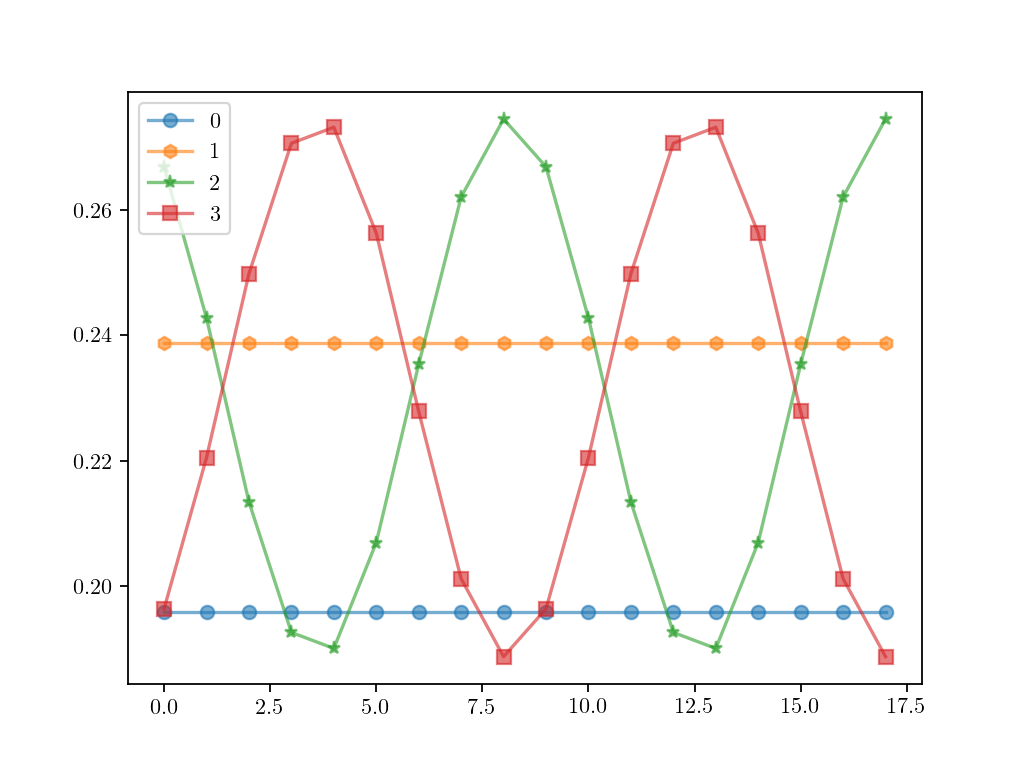

In [43]:
for i,yy in enumerate(yy_lst):
    plot(range(L),yy,mks[i]+'-',label=i,alpha=.6)
legend(loc=0)

In [35]:
va_sts=valid_states(L)
m2M,M2m=build_st_dicitonaries(va_sts)
Hin=Hpxp_inho(L,va_sts,M2m)
print(len(va_sts))

5778


In [36]:
win,vin=eigh(Hin)

In [44]:
nstates=4
yy_lst=[[] for i in range(nstates)]
for i in range(nstates):
    yy_lst[i]=[real(dot(dot(conjugate(vin[:,i]),ox[x]),vin[:,i])) for x in range(L)]

<IPython.core.display.Javascript object>


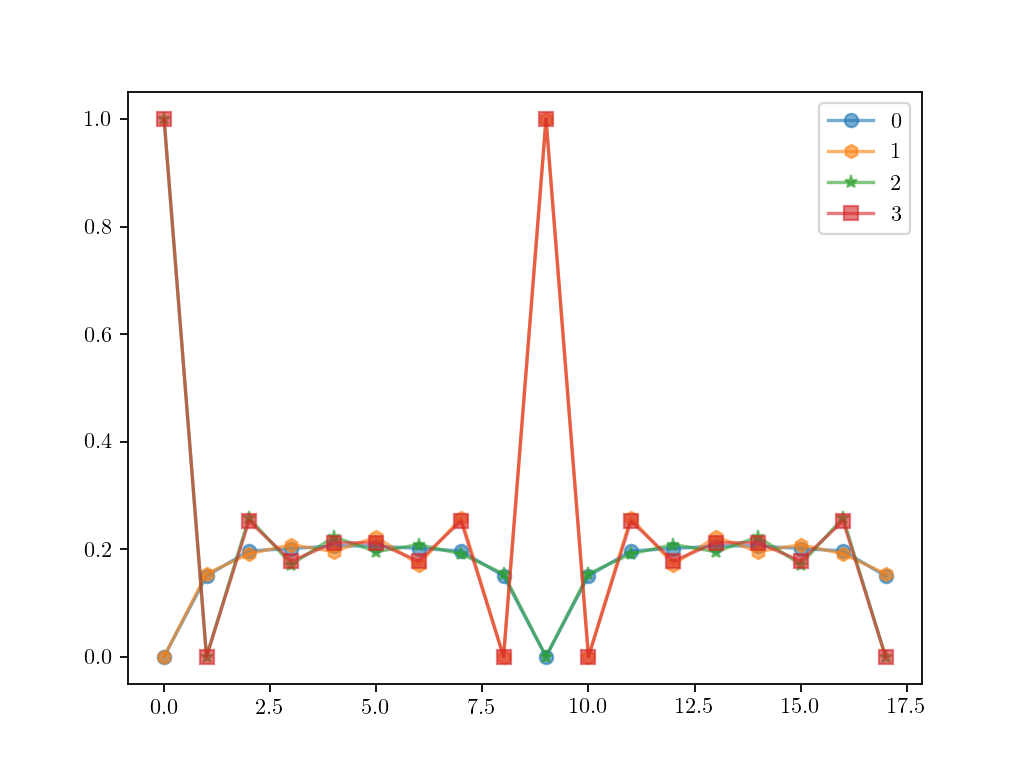

In [46]:
for i,yy in enumerate(yy_lst[]):
    plot(range(L),yy,mks[i]+'-',label=i,alpha=.6)
legend(loc=0)

In [50]:
plot(range(L),yy_lst[1],mks[i]+'-',label=i,alpha=.6)

<IPython.core.display.Javascript object>


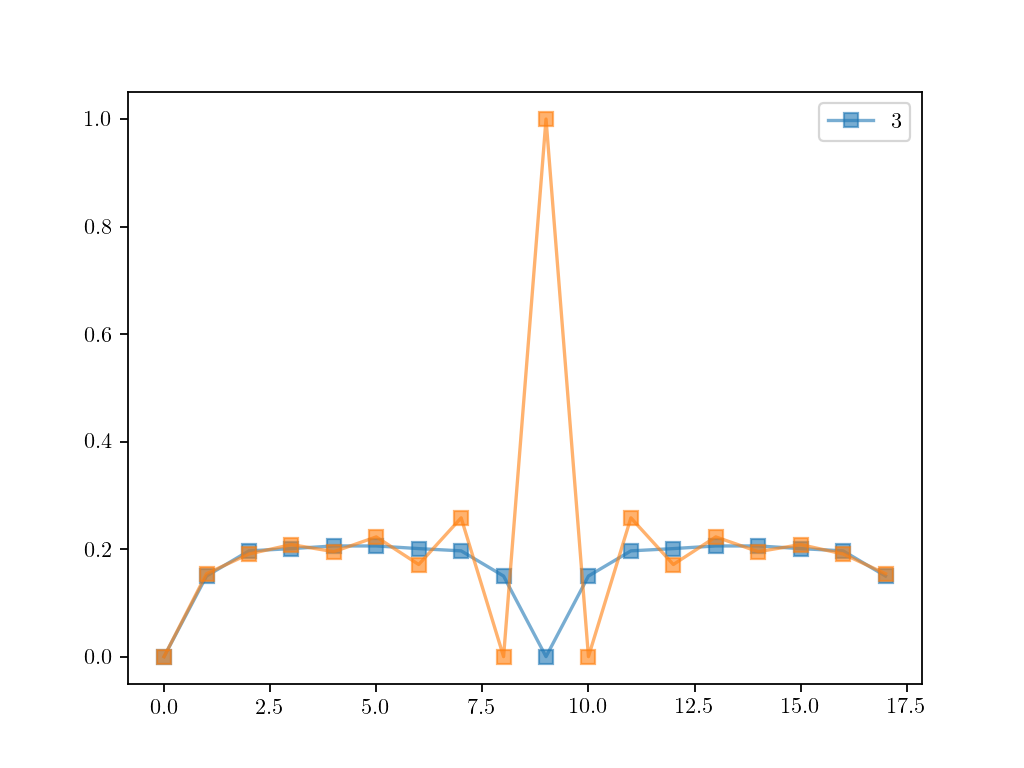

In [49]:
plot(range(L),yy_lst[0],mks[i]+'-',label=i,alpha=.6)
legend(loc=0)

## Inhomogeneity

In [34]:
def Hpxp_inho(L,valid_states,M2m):
    N=len(valid_states)
    H=zeros((N,N),complex)
    for m1,st in enumerate(valid_states):
        for i in range(L):
            if st[(i-1)%L]==0 and st[(i+1)%L]==0:
                new_st=deepcopy(st)
                new_st[i]=1-st[i]
                M=int(''.join(map(str,new_st)))
                m2=M2m[M]
                H[m2,m1]=sin(2*pi*i/L)**2
    return H

def the_maxs(xx,yy):
    max_xx=[0]
    max_yy=[yy[0]]
    for i in range(1,len(yy)-1):
        if yy[i]>yy[i-1] and yy[i]>yy[i+1]:
            max_xx+=[xx[i]]
            max_yy+=[yy[i]]
    return max_xx,max_yy

In [22]:
L=15

In [23]:
va_sts=valid_states(L)
m2M,M2m=build_st_dicitonaries(va_sts)
H=Hpxp(L,va_sts,M2m)
Hin=Hpxp_inho(L,va_sts,M2m)
print(len(va_sts))

1364


In [8]:
w,v=eigh(H)
win,vin=eigh(Hin)

<IPython.core.display.Javascript object>


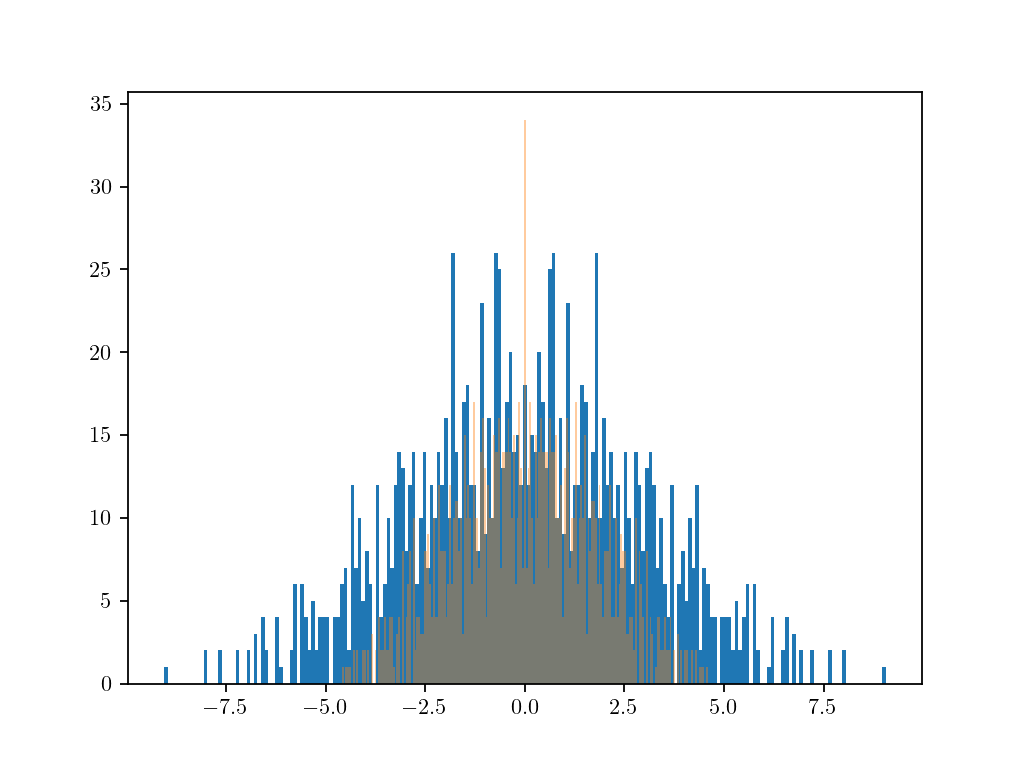

(array([ 1.,  0.,  1.,  1.,  1.,  0.,  2.,  0.,  2.,  0.,  0.,  2.,  2.,
         0.,  2.,  0.,  3.,  0.,  2.,  0.,  4.,  2.,  2.,  4.,  2.,  2.,
         4.,  4.,  1.,  0.,  3.,  4.,  0.,  8.,  0.,  4.,  6.,  8.,  0.,
        10.,  2.,  4.,  4.,  3.,  3.,  8.,  8.,  9.,  6.,  4., 10.,  4.,
         4., 12.,  8.,  8.,  8.,  4.,  6., 12.,  6., 10., 11., 11.,  8.,
        10.,  3., 15., 10., 12., 10.,  6., 17., 10., 10.,  7., 14., 16.,
        13.,  4., 12., 10., 10., 15., 14., 14., 16.,  7., 14., 14., 14.,
        16., 14., 10., 15.,  6., 10., 17., 13.,  7., 34.,  7., 13., 17.,
        10.,  6., 15., 10., 14., 16., 14., 14., 14.,  7., 16., 14., 14.,
        15., 10., 10., 12.,  4., 13., 16., 14.,  7., 10., 10., 17.,  6.,
        10., 12., 10., 15.,  3., 10.,  8., 11., 11., 10.,  6., 12.,  6.,
         4.,  8.,  8.,  8., 12.,  4.,  4., 10.,  4.,  6.,  9.,  8.,  8.,
         3.,  3.,  4.,  4.,  2., 10.,  0.,  8.,  6.,  4.,  0.,  8.,  0.,
         4.,  3.,  0.,  1.,  4.,  4.,  2.,  2.,  4.

In [20]:
hist(w,bins=201)
hist(win,bins=201,alpha=.4)

Much more zero modes for the inhomogeneous case.

In [24]:
Obs=zeros((len(va_sts),len(va_sts)),complex)
for i,st in enumerate(va_sts):
    Obs[i,i]=(2*sum(st)-L)/L

In [25]:
dt=.05
U=expm(-1.j*dt*H)
Uin=expm(-1.j*dt*Hin)

<IPython.core.display.Javascript object>


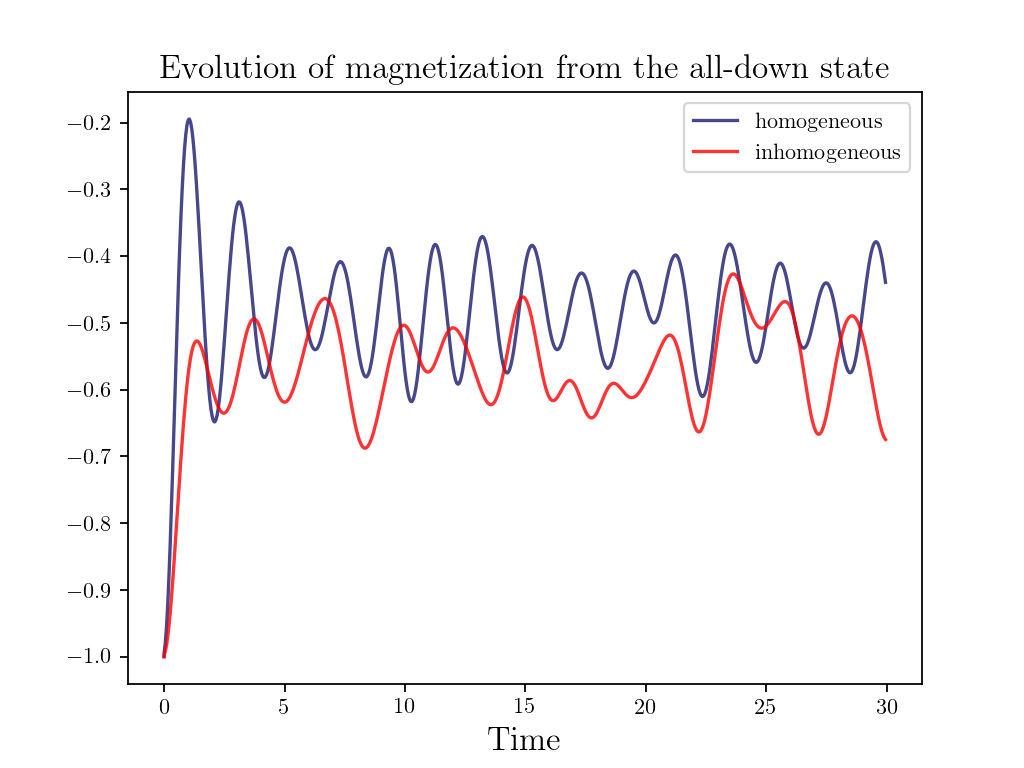

Text(0.5, 1.0, 'Evolution of magnetization from the all-down state')

In [32]:
labs=['homogeneous','inhomogeneous']
cls=['midnightblue','red']
for j,u in enumerate([U,Uin]):
    v0=zeros(len(u),complex)
    v0[0]=1.
    xx=[0]
    yy=[dot(v0,dot(Obs,v0))]
    for i in range(600):
        xx+=[i*dt]
        v0=dot(u,v0)
        yy+=[real(dot(conjugate(v0),dot(Obs,v0)))]
    plot(xx,yy,'-',alpha=.8,label=labs[j],color=cls[j])
legend(loc=0)
xlabel('Time',size=15)
legend(loc=0)
title('Evolution of magnetization from the all-down state for $L=15$',size=15)

<IPython.core.display.Javascript object>


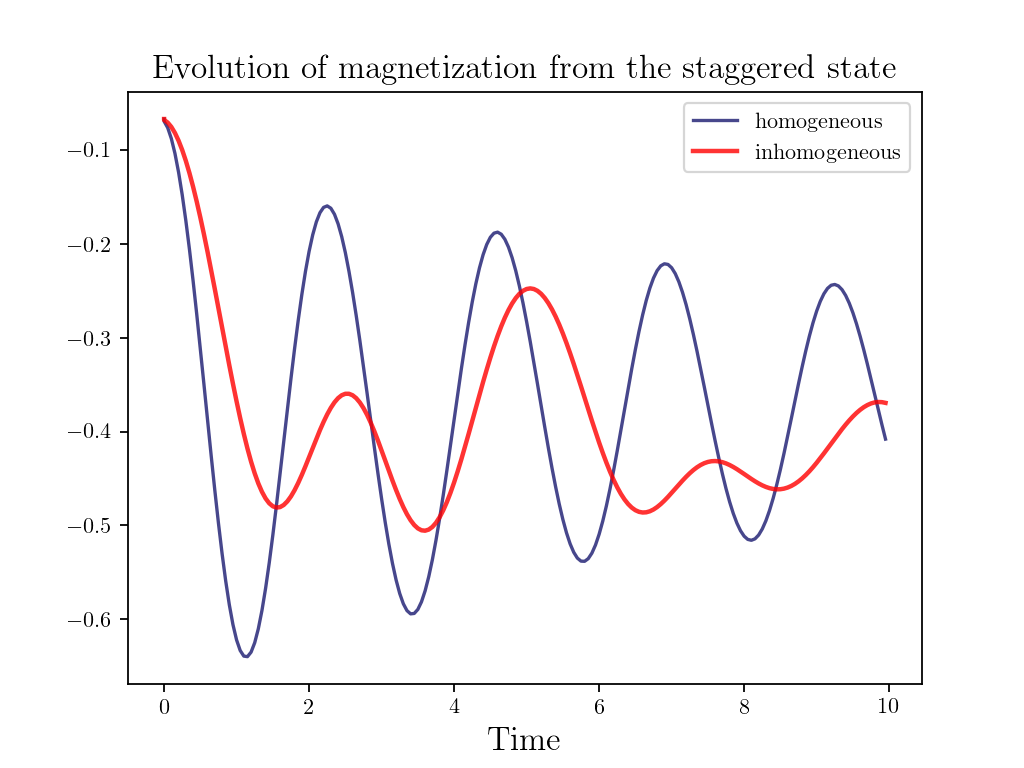

Text(0.5, 1.0, 'Evolution of magnetization from the staggered state')

In [30]:
labs=['homogeneous','inhomogeneous']
cls=['midnightblue','red']

v0=zeros(len(U),complex)
v0[-1]=1.
xx=[0]
yy=[dot(v0,dot(Obs,v0))]
for i in range(200):
    xx+=[i*dt]
    v0=dot(U,v0)
    yy+=[real(dot(conjugate(v0),dot(Obs,v0)))]
plot(xx,yy,'-',alpha=.8,label=labs[0],color=cls[0])
max_xx,max_yy=the_maxs(xx,yy)

v0=zeros(len(Uin),complex)
v0[-1]=1.
xx=[0]
yy=[dot(v0,dot(Obs,v0))]
for i in range(200):
    xx+=[i*dt]
    v0=dot(Uin,v0)
    yy+=[real(dot(conjugate(v0),dot(Obs,v0)))]
plot(xx,yy,'-',alpha=.8,label=labs[1],color=cls[1],linewidth=2)
max_xx_in,max_yy_in=the_maxs(xx,yy)

xlabel('Time',size=15)
legend(loc=0)
title('Evolution of magnetization from the staggered state',size=15)

In [37]:
labs=['homogeneous','inhomogeneous']
cls=['midnightblue','red']

In [39]:
v0=zeros(len(U),complex)
v0[-1]=1.
xx=[0]
yy=[dot(v0,dot(Obs,v0))]
for i in range(600):
    xx+=[i*dt]
    v0=dot(U,v0)
    yy+=[real(dot(conjugate(v0),dot(Obs,v0)))]
plot(xx,yy,'-',alpha=.8,label=labs[0],color=cls[0])
#max_xx,max_yy=the_maxs(xx,yy)

#v0=zeros(len(Uin),complex)
#v0[-1]=1.
#xx=[0]
#yy=[dot(v0,dot(Obs,v0))]
#for i in range(600):
#    xx+=[i*dt]
#    v0=dot(Uin,v0)
#    yy+=[real(dot(conjugate(v0),dot(Obs,v0)))]
#plot(xx,yy,'-',alpha=.8,label=labs[1],color=cls[1],linewidth=2)
#max_xx_in,max_yy_in=the_maxs(xx,yy)

#xlabel('Time',size=15)
#legend(loc=0)
#title('Evolution of magnetization from the staggered state',size=15)

<IPython.core.display.Javascript object>


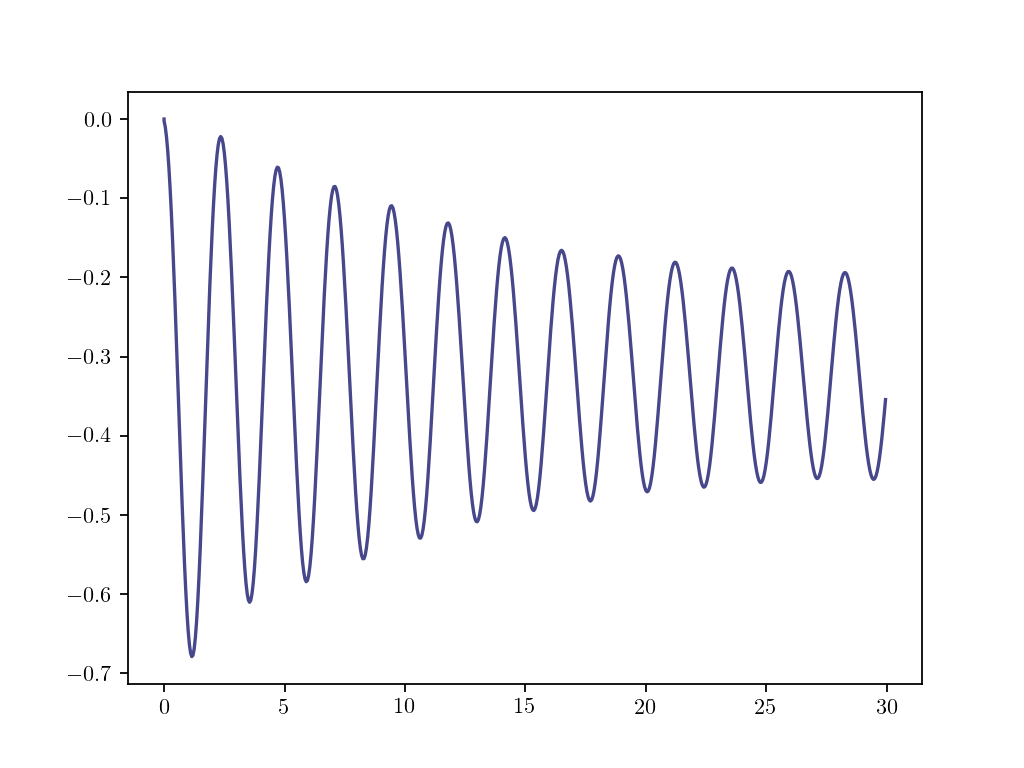

/home/joao/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [46]:
plot(xx,yy,'-',alpha=.8,label=labs[0],color=cls[0])
savefig('PXP_evol.png',dpi=300)

<IPython.core.display.Javascript object>


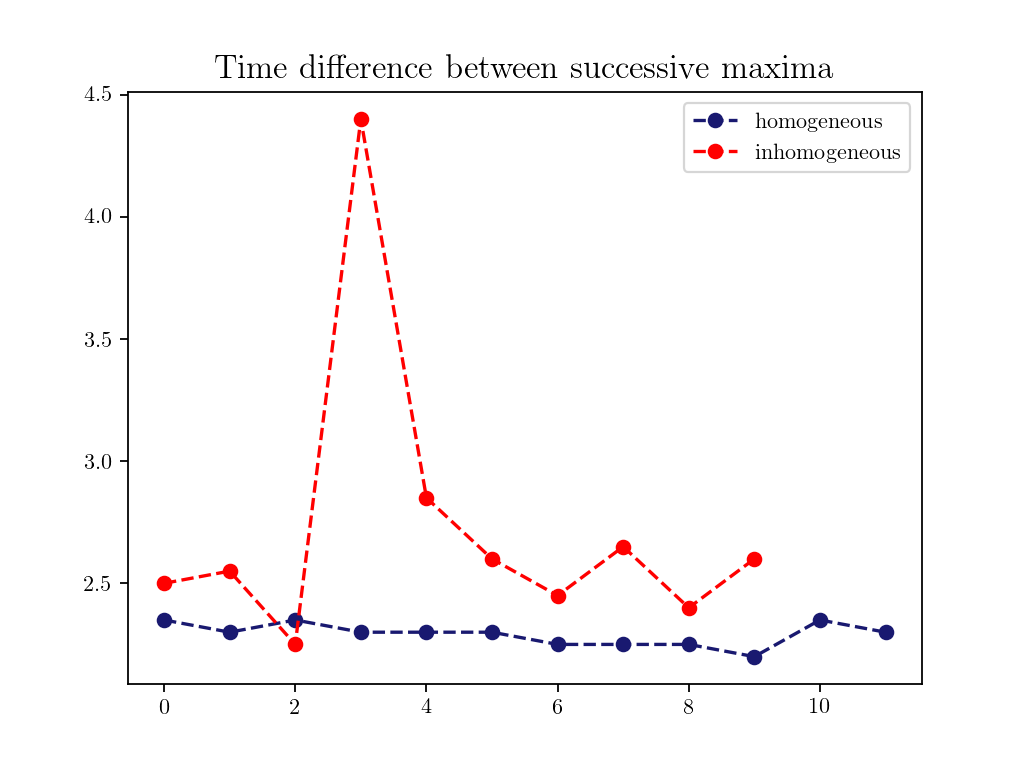

In [23]:
xran=range(len(max_xx)-1)
plot(xran,[max_xx[i+1]-max_xx[i] for i in range(len(max_xx)-1)],'o--',color='midnightblue',label=labs[0])
xran=range(len(max_xx_in)-1)
plot(xran,[max_xx_in[i+1]-max_xx_in[i] for i in range(len(max_xx_in)-1)],'o--',color='red',label=labs[1])
title('Time difference between successive maxima',size=15)
legend(loc=0)

In [6]:
L=18

In [34]:
va_sts=valid_states(L)
m2M,M2m=build_st_dicitonaries(va_sts)
H=Hpxp(L,va_sts,M2m)
Hin=Hpxp_inho(L,va_sts,M2m)
print(len(va_sts))

NameError: name 'Hpxp_inho' is not defined

In [32]:
Obs=zeros((len(va_sts),len(va_sts)),complex)
for i,st in enumerate(va_sts):
    Obs[i,i]=(2*sum(st)-L)/L

In [35]:
dt=.05
U=expm(-1.j*dt*H)
#Uin=expm(-1.j*dt*Hin)

<IPython.core.display.Javascript object>


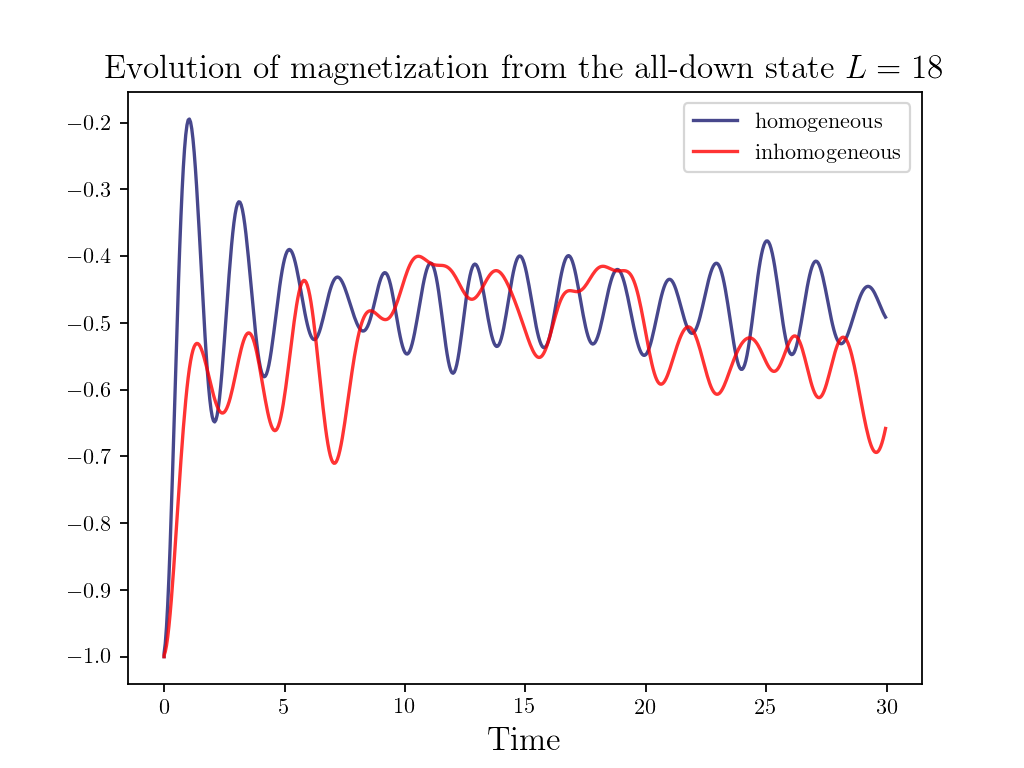

/home/joao/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Evolution of magnetization from the all-down state $L=18$')

In [21]:
labs=['homogeneous','inhomogeneous']
cls=['midnightblue','red']
for j,u in enumerate([U,Uin]):
    v0=zeros(len(u),complex)
    v0[0]=1.
    xx=[0]
    yy=[dot(v0,dot(Obs,v0))]
    for i in range(600):
        xx+=[i*dt]
        v0=dot(u,v0)
        yy+=[real(dot(conjugate(v0),dot(Obs,v0)))]
    plot(xx,yy,'-',alpha=.8,label=labs[j],color=cls[j])
legend(loc=0)
xlabel('Time',size=15)
legend(loc=0)
title('Evolution of magnetization from the all-down state $L=18$',size=15)

<IPython.core.display.Javascript object>


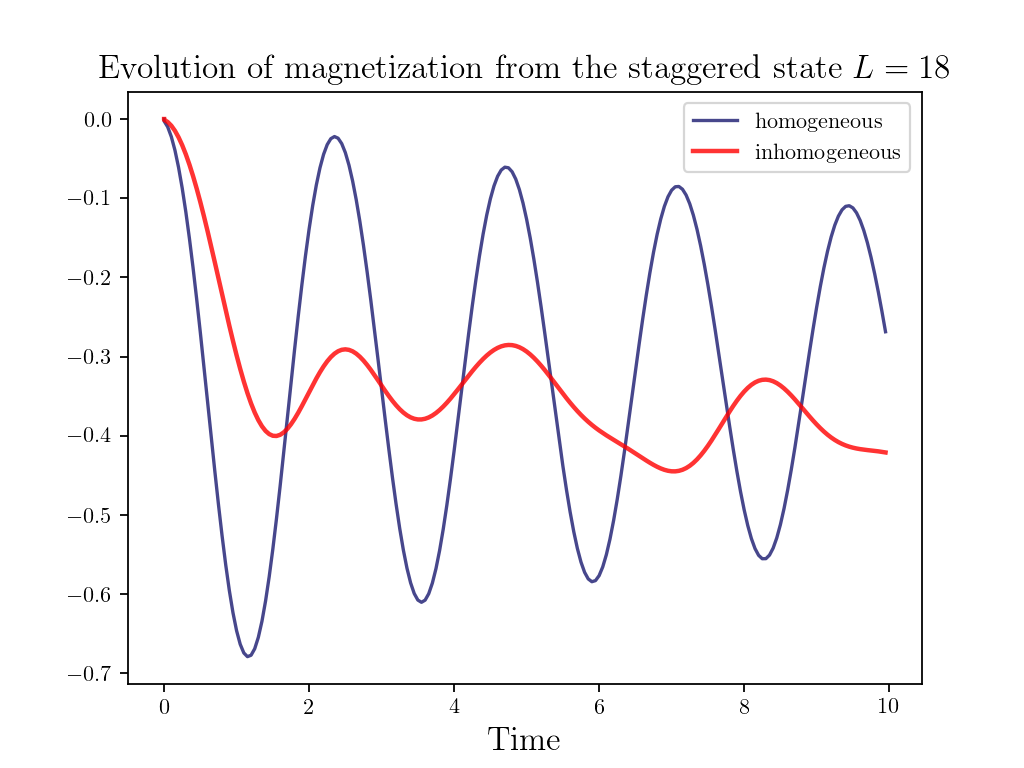

/home/joao/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Evolution of magnetization from the staggered state $L=18$')

In [13]:
labs=['homogeneous','inhomogeneous']
cls=['midnightblue','red']

v0=zeros(len(U),complex)
v0[-1]=1.
xx=[0]
yy=[dot(v0,dot(Obs,v0))]
for i in range(200):
    xx+=[i*dt]
    v0=dot(U,v0)
    yy+=[real(dot(conjugate(v0),dot(Obs,v0)))]
plot(xx,yy,'-',alpha=.8,label=labs[0],color=cls[0])
max_xx,max_yy=the_maxs(xx,yy)

v0=zeros(len(Uin),complex)
v0[-1]=1.
xx=[0]
yy=[dot(v0,dot(Obs,v0))]
for i in range(200):
    xx+=[i*dt]
    v0=dot(Uin,v0)
    yy+=[real(dot(conjugate(v0),dot(Obs,v0)))]
plot(xx,yy,'-',alpha=.8,label=labs[1],color=cls[1],linewidth=2)
max_xx_in,max_yy_in=the_maxs(xx,yy)

xlabel('Time',size=15)
legend(loc=0)
title('Evolution of magnetization from the staggered state $L=18$',size=15)

<IPython.core.display.Javascript object>


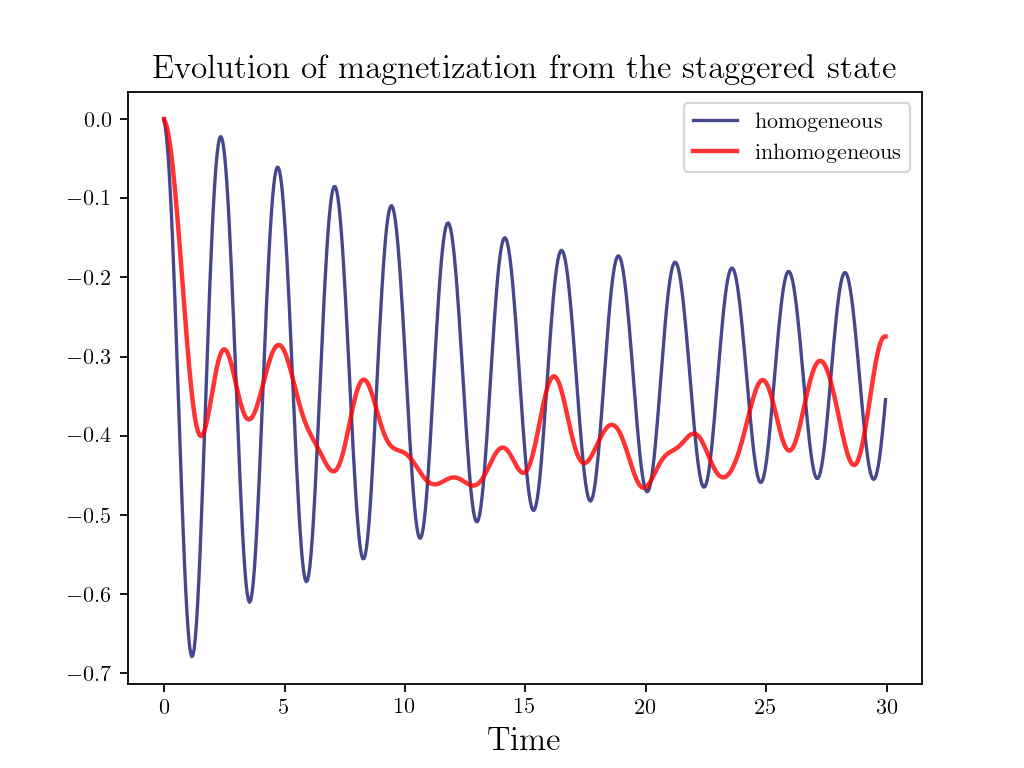

Text(0.5, 1.0, 'Evolution of magnetization from the staggered state')

In [18]:
v0=zeros(len(U),complex)
v0[-1]=1.
xx=[0]
yy=[dot(v0,dot(Obs,v0))]
for i in range(600):
    xx+=[i*dt]
    v0=dot(U,v0)
    yy+=[real(dot(conjugate(v0),dot(Obs,v0)))]
plot(xx,yy,'-',alpha=.8,label=labs[0],color=cls[0])
max_xx,max_yy=the_maxs(xx,yy)

v0=zeros(len(Uin),complex)
v0[-1]=1.
xx=[0]
yy=[dot(v0,dot(Obs,v0))]
for i in range(600):
    xx+=[i*dt]
    v0=dot(Uin,v0)
    yy+=[real(dot(conjugate(v0),dot(Obs,v0)))]
plot(xx,yy,'-',alpha=.8,label=labs[1],color=cls[1],linewidth=2)
max_xx_in,max_yy_in=the_maxs(xx,yy)

xlabel('Time',size=15)
legend(loc=0)
title('Evolution of magnetization from the staggered state',size=15)

<IPython.core.display.Javascript object>


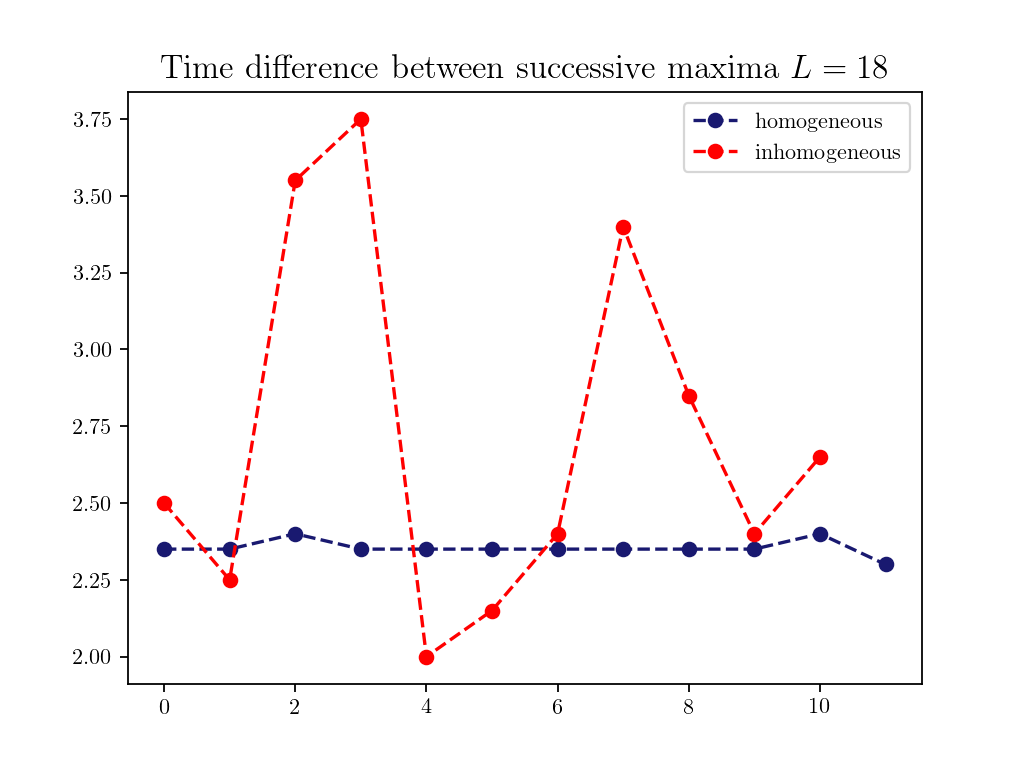

In [20]:
xran=range(len(max_xx)-1)
plot(xran,[max_xx[i+1]-max_xx[i] for i in range(len(max_xx)-1)],'o--',color='midnightblue',label=labs[0])
xran=range(len(max_xx_in)-1)
plot(xran,[max_xx_in[i+1]-max_xx_in[i] for i in range(len(max_xx_in)-1)],'o--',color='red',label=labs[1])
title('Time difference between successive maxima $L=18$',size=15)
legend(loc=0)

## Inhomogeneity to free spins

In [14]:
def Hpxp_inho(L,valid_states,M2m):
    N=len(valid_states)
    H=zeros((N,N),complex)
    for m1,st in enumerate(valid_states):
        for i in range(L):
            alpha=1-sin(2*pi*i/L)**2
            fact=alpha**(st[(i-1)%L]+st[(i+1)%L])
            new_st=deepcopy(st)
            new_st[i]=1-st[i]
            M=int(''.join(map(str,new_st)))
            m2=M2m[M]
            H[m2,m1]=fact
    return H

In [17]:
L=15

va_sts=valid_states(L)
m2M,M2m=build_st_dicitonaries(va_sts)
H=Hpxp(L,va_sts,M2m)
Hin=Hpxp_inho(L,va_sts,M2m)
print(len(va_sts))

KeyError: 110000000000000

In [15]:
Obs=zeros((len(va_sts),len(va_sts)),complex)
for i,st in enumerate(va_sts):
    Obs[i,i]=(2*sum(st)-L)/L

In [16]:
dt=.05
U=expm(-1.j*dt*H)
Uin=expm(-1.j*dt*Hin)

KeyboardInterrupt: 

In [ ]:
labs=['homogeneous','inhomogeneous']
cls=['midnightblue','red']
for j,u in enumerate([U,Uin]):
    v0=zeros(len(u),complex)
    v0[0]=1.
    xx=[0]
    yy=[dot(v0,dot(Obs,v0))]
    for i in range(600):
        xx+=[i*dt]
        v0=dot(u,v0)
        yy+=[real(dot(conjugate(v0),dot(Obs,v0)))]
    plot(xx,yy,'-',alpha=.8,label=labs[j],color=cls[j])
legend(loc=0)
xlabel('Time',size=15)
legend(loc=0)
title('Evolution of magnetization from the all-down state for $L=15$',size=15)